# 1. 라이브러리 불러오기

In [1]:
import re
import os
import sys
import platform

import warnings
warnings.filterwarnings(action = 'ignore')

import pandas as pd
import numpy as np

pd.set_option('max.columns', 1000)
pd.set_option('max.rows', 20)
pd.options.display.float_format = '{:.5f}'.format

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    plt.rcParams['font.family'] = 'AppleGothic'

import statsmodels.api as sm
from scipy import stats

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# 2. 분석과정에 필요한 함수 생성

In [2]:
# 이상치가 존재하면 상한, 하한값으로 대체해주는 함수 생성
def outlier_transformer(raw_data = None, column = None, weight = None):
    
    '''
    Docstring:
    한 변수에 이상치가 존재하는 경우, 이상치를 상한, 하한값으로 대체해주는 함수
    
    Parameters
    ----------
    raw_data: pd.DataFrame 타입의 데이터프레임을 넣어준다.
    
    column: String, 이상치를 탐지하고 대체할 변수명을 직접 입력해준다.
    
    weight: Float, 이상치를 판단할 때 IQR에 가중치를 얼마나 부여할지를 의미한다.
    '''
    
    # 데이터 보존을 위해 데이터 복사
    data = raw_data.copy()
    
    # 1사분위수, 3사분위수 구하기
    quan_25 = np.quantile(data[column], 0.25)
    quan_75 = np.quantile(data[column], 0.75)
    
    IQR = quan_75 - quan_25
    IQR_weight = IQR * weight
    
    lowest = quan_25 - IQR_weight
    highest = quan_75 + IQR_weight
    
    # 이상치가 존재하는 경우 상한값, 하한값으로 변경
    data[column] = data[column].apply(lambda x: quan_75 if x >= highest else x)
    data[column] = data[column].apply(lambda x: quan_25 if x <= lowest else x)
    
    return data[column]

In [3]:
# 한 변수에 대한 시각화를 수행해주는 함수 생성
def one_variable_plot(plot_data = None, column = None):
    
    '''
    Docstring:
    한 변수에 대해서 Histogram, Boxplot을 시각화해준다.
    또한, 현재 수도권 데이터이기 때문에 서울, 경기, 인천으로 나누어 Histogram을 시각화해준다.
    
    Parameters
    ----------
    plot_data: pd.DataaFrame 타입의 데이터프레임을 넣어준다.
    
    column: String, 지정한 데이터프레임에서 탐색할 변수명을 직접 입력해준다.
    '''
    
    # 시각화 틀 생성
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4))
    
    # Histogram
    sns.histplot(data = plot_data, x = column, kde = True, line_kws = {'linewidth' : 5, 'linestyle' : '--'}, ax = axes[0])
    axes[0].set_ylabel('')
    
    # 시도별 Histogram
    sns.histplot(data = plot_data, x = column, hue = '시도명', ax = axes[1])
    axes[1].set_ylabel('')
    
    # Boxplot
    sns.boxplot(data = plot_data, x = column, color = 'salmon', ax = axes[2])
    
    fig.tight_layout()

In [4]:
# 대체_재활용 변수와 독립변수의 상관분석을 수행하고 산점도를 그려주는 함수 생성
def correlation_scatter(plot_data = None, column = None):
    
    '''
    Dicstring:
    현재 종속변수가 '대체_재활용'이며, 해당 변수와 상관분석을 수행한 결과와 산점도를 시각화해주는 함수
    
    Parameters
    ----------
    plot_data: pd.DataFrame 타입의 데이터프레임을 넣어준다.
    
    column: String, 지정한 데이터프레임에서 종속변수와의 상관분석과 시각화를 수행할 변수명을 직접 입력해준다.
    '''
    
    # 상관분석 수행
    stat, p_val = stats.pearsonr(plot_data[column], plot_data['대체_재활용'])
    print('상관계수 :', np.round(stat, 4), '\n')
    print('유의확률 :', np.round(p_val, 4), '\n')
    
    # 시각화 과정
    plt.figure(figsize = (10, 5))
    
    sns.scatterplot(x = column, y = '대체_재활용', data = plot_data)
    plt.show()

In [5]:
# 이상치를 상한, 하한값으로 대체, 로그 변환, Robust, Standard, MinMax 5가지를 수행하고 확인해주는 함수 생성
def area_detection(raw_data = None, column = None, return_value = None):
    
    '''
    Docstring:
    면적 관련 변수의 경우, 면적을 나타내기 때문에 전체적으로 값들이 크고 편차도 심하다는 것을 확인할 수 있었다.
    따라서, 면적 관련 변수의 이상치를 상한, 하한값으로 대체, 로그 변환, Robust Scaling, Standard Scaling, MinMax Scaling
    총 5가지의 방법을 사용하고, 각 방법들로 대체했을 때의 분포와 왜도를 확인할 수 있는 함수를 생성하였다.
    
    Parameters
    ----------
    raw_data: pd.DataFrame 타입의 데이터프레임을 넣어준다.
    
    column: String, 지정한 데이터프레임에서 이상치를 탐지하고 대체할 변수명을 직접 입력해준다.
    
    return_value: 'replace', 'log', 'robust', 'standard', 'minmax'
                  5가지의 방법 중에서 적절하다고 판단되는 한 가지의 방법을 선택하면, 변수를 선택한 방법으로 변환해준다.
    '''
    
    # 데이터 보존을 위한 데이터 복사
    data = raw_data.copy()
    
    # 이상치를 상한, 하한값으로 대체
    replace_value = outlier_transformer(raw_data = data, column = column, weight = 1.5)
    replace_skew = np.round(stats.skew(replace_value), 3)
    
    # 로그를 사용하여 데이터 변환
    log_value = np.log1p(data[column])
    log_skew = np.round(stats.skew(log_value), 3)
    
    # Robust Scaling
    robust = RobustScaler()
    robust_value = pd.Series(robust.fit_transform(data[column].values.reshape(-1, 1)).reshape(-1))
    robust_skew = np.round(stats.skew(robust_value), 3)
    
    # Standard Scaling
    standard = StandardScaler()
    standard_value = pd.Series(standard.fit_transform(data[column].values.reshape(-1, 1)).reshape(-1))
    standard_skew = np.round(stats.skew(standard_value), 3)
    
    # MinMax Scaling
    minmax = MinMaxScaler()
    minmax_value = pd.Series(minmax.fit_transform(data[column].values.reshape(-1, 1)).reshape(-1))
    minmax_skew = np.round(stats.skew(minmax_value), 3)
    
    # 시각화 틀 생성
    fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (18, 5))
    
    value_list = [replace_value, log_value, robust_value, standard_value, minmax_value]
    skew_list = [replace_skew, log_skew, robust_skew, standard_skew, minmax_skew]
    outlier_name = ['이상치 상한, 하한값으로 대체', 'Log 변환', 'Robust Scaling', 'Standard Scaling', 'MinMax Scaling']
    
    for index, [value, skew, title] in enumerate(zip(value_list, skew_list, outlier_name)):
        
        # 각 변수에 대해서 Histogram 시각화
        sns.histplot(value, kde = True, line_kws = {'linewidth' : 3, 'linestyle' : '--'}, ax = axes[index])
        axes[index].set_title(title + '\n' + '왜도 = {}'.format(skew), fontsize = 11)
        axes[index].set_xlabel('')
        axes[index].set_ylabel('')
    
    fig.tight_layout()
    
    # return_value 매개변수에 값을 입력해주면, 값이 반환된다.
    if return_value == 'replace':
        return replace_value
    
    elif return_value == 'log':
        return log_value
    
    elif return_value == 'robust':
        return robust_value
    
    elif return_value == 'standard':
        return standard_value
    
    elif return_value == 'minmax':
        return minmax_value
    
    else:
        pass

# 3. 데이터 불러오기

## 3.1 수도권 생활폐기물 데이터

In [8]:
# 수도권 생활폐기물 데이터 불러오기
생활폐기물 = pd.read_excel('./수도권 Data/(수도권) 생활폐기물_2019.xlsx', header = 4)

# Excel 파일 형태라 깨지는 부분 삭제
생활폐기물.drop(['Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)

# 변수명 변경
생활폐기물.columns = ['시도명', '시군구명', '폐기물종류', '2019년 발생량', '재활용', '소각', '매립', '기타', '공공처리 재활용', '공공처리 소각', 
                   '공공처리 매립', '공공처리 기타', '자가처리 재활용', '자가처리 소각', '자가처리 매립', '자가처리 기타', '위탁처리 재활용', 
                   '위탁처리 소각', '위탁처리 매립', '위탁처리 기타']

# 데이터 일부 확인
display(생활폐기물.head())

,시도명,시군구명,폐기물종류,2019년 발생량,재활용,소각,매립,기타,공공처리 재활용,공공처리 소각,공공처리 매립,공공처리 기타,자가처리 재활용,자가처리 소각,자가처리 매립,자가처리 기타,위탁처리 재활용,위탁처리 소각,위탁처리 매립,위탁처리 기타
0,서울,종로구,합계,339.90000,219.60000,79.90000,40.30000,0.10000,55.10000,79.10000,40.30000,0.00000,0.40000,0.00000,0.00000,0.00000,164.10000,0.80000,0.00000,0.10000
1,서울,중구,합계,413.70000,224.30000,133.90000,55.50000,0.00000,0.00000,133.30000,55.50000,0.00000,0.00000,0.00000,0.00000,0.00000,224.30000,0.60000,0.00000,0.00000
2,서울,용산구,합계,305.20000,198.60000,69.30000,31.30000,6.00000,23.60000,59.70000,29.90000,0.00000,0.00000,0.00000,0.00000,0.00000,175.00000,9.60000,1.40000,6.00000
3,서울,성동구,합계,303.10000,211.40000,62.60000,27.10000,2.00000,21.90000,60.40000,27.10000,0.00000,0.00000,0.00000,0.00000,0.00000,189.50000,2.20000,0.00000,2.00000
4,서울,광진구,합계,333.90000,253.20000,59.10000,21.20000,0.40000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,253.20000,59.10000,21.20000,0.40000


In [9]:
# 사용할 변수만 저장
생활폐기물 = 생활폐기물[['시도명', '시군구명', '재활용']]

# 데이터 일부 확인
print('수도권 생활폐기물 데이터 행과열 :', 생활폐기물.shape, '\n')
display(생활폐기물.head())

수도권 생활폐기물 데이터 행과열 : (66, 3) 



,시도명,시군구명,재활용
0,서울,종로구,219.60000
1,서울,중구,224.30000
2,서울,용산구,198.60000
3,서울,성동구,211.40000
4,서울,광진구,253.20000


## 3.2 수도권 1인가구비율 데이터

In [10]:
# 수도권 1인가구비율 데이터 불러오기
가구비율 = pd.read_csv('수도권 Data/(수도권) 1인가구비율_2019.csv', encoding = 'UTF-8', header = 1)
가구비율.rename(columns = {'Unnamed: 0' : '시도명'}, inplace = True)

# 데이터 일부 확인
display(가구비율.head())

,시도명,행정구역별,1인가구비율<br>(A÷B×100) (%),1인가구<br>(A) (가구),일반가구<br>(B) (가구)
0,서울특별시,서울특별시,33.4,1299787,3896389
1,서울특별시,종로구,39.4,24671,62652
2,서울특별시,중구,40.5,22078,54496
3,서울특별시,용산구,37.7,35148,93177
4,서울특별시,성동구,33.8,41488,122770


In [11]:
# 행정구역별 변수에서 '서울특별시', '경기도', '인천광역시', '남구' 제거
가구비율 = 가구비율[~가구비율['행정구역별'].isin(['서울특별시', '경기도', '인천광역시', '남구'])].reset_index(drop = True)

# 변수 이름 변경
가구비율.columns = ['시도명', '시군구명', '1인가구비율', '1인가구', '일반가구']

# 데이터 병합을 위해 시도명 변수의 값 바꿔주기
가구비율.loc[가구비율['시도명'] == '서울특별시', '시도명'] = '서울'
가구비율.loc[가구비율['시도명'] == '인천광역시', '시도명'] = '인천'
가구비율.loc[가구비율['시도명'] == '경기도', '시도명'] = '경기'

# 1인가구비율, 1인가구, 일반가구 변수 숫자형으로 변환
가구비율['1인가구비율'] = 가구비율['1인가구비율'].astype('float')
가구비율['1인가구'] = 가구비율['1인가구'].astype('int')
가구비율['일반가구'] = 가구비율['일반가구'].astype('int')

# 데이터 일부 확인
print('수도권 가구비율 데이터 행과열 :', 가구비율.shape, '\n')
display(가구비율.head())

수도권 가구비율 데이터 행과열 : (66, 5) 



,시도명,시군구명,1인가구비율,1인가구,일반가구
0,서울,종로구,39.40000,24671,62652
1,서울,중구,40.50000,22078,54496
2,서울,용산구,37.70000,35148,93177
3,서울,성동구,33.80000,41488,122770
4,서울,광진구,39.20000,58714,149905


## 3.3 수도권 인구_가구_주택현황 데이터

In [13]:
# 수도권 인구, 가구, 주택 데이터 불러오기
인구_가구_주택 = pd.read_csv('./수도권 Data/(수도권) 인구_가구_주택_2019.csv', encoding = 'UTF-8', header = 1)

# 데이터 일부 확인
display(인구_가구_주택.head())

,서울,행정구역별(읍면동),총인구 (명),남자 (명),여자 (명),내국인-계 (명),내국인-남자 (명),내국인-여자 (명),외국인-계 (명),외국인-남자 (명),외국인-여자 (명),가구-계 (가구),일반가구 (가구),집단가구 (가구),외국인가구 (가구),주택-계 (호),단독주택 (호),아파트 (호),연립주택 (호),다세대주택 (호),비거주용 건물내 주택 (호),주택이외의 거처 (호)
0,서울,서울특별시,9639541,4690440,4949101,9249364,4500878,4748486,390177,189562,200615,4043957,3896389,2328,145240,2953964,315566,1720691,110968,777205,29534,224878
1,서울,종로구,154969,74880,80089,141810,69062,72748,13159,5818,7341,67650,62652,113,4885,46440,12421,15290,5459,12349,921,5084
2,서울,중구,130957,63406,67551,118398,57381,61017,12559,6025,6534,59440,54496,98,4846,41754,6035,25823,1940,7095,861,5286
3,서울,용산구,227181,110934,116247,206678,99313,107365,20503,11621,8882,99777,93177,80,6520,72463,14487,36181,3959,17107,729,6151
4,서울,성동구,299688,146630,153058,287914,141020,146894,11774,5610,6164,127557,122770,79,4708,91037,10782,67058,2021,10095,1081,5851


In [14]:
# 행정구역별 변수에서 '서울특별시', '경기도', '인천광역시' 제거
인구_가구_주택 = 인구_가구_주택[~인구_가구_주택['행정구역별(읍면동)'].isin(['서울특별시', '인천광역시', '경기도'])].reset_index(drop = True)

# 분석에 사용할 변수만 추출
인구_가구_주택 = 인구_가구_주택[['서울', '행정구역별(읍면동)', '총인구 (명)', '내국인-계 (명)', '외국인-계 (명)']]
인구_가구_주택.columns = ['시도명', '시군구명', '총인구', '내국인', '외국인']

# 데이터 일부 확인
print('수도권 인구, 가구, 주택 데이터 행과열 :', 인구_가구_주택.shape, '\n')
display(인구_가구_주택.head())

수도권 인구, 가구, 주택 데이터 행과열 : (66, 5) 



,시도명,시군구명,총인구,내국인,외국인
0,서울,종로구,154969,141810,13159
1,서울,중구,130957,118398,12559
2,서울,용산구,227181,206678,20503
3,서울,성동구,299688,287914,11774
4,서울,광진구,359766,338841,20925


## 3.4 수도권 시군구별 면적 데이터

In [16]:
# 수도권 면적 데이터 불러오기
면적 = pd.read_csv('./수도권 Data/(수도권) 면적_2019.csv', encoding = 'CP949', header = 2)
면적.rename(columns = {'면적 (㎡)' : '총면적', '면적 (㎡).1' : '도시지역면적', '면적 (㎡).2' : '비도시지역면적'}, inplace = True)

# 데이터 일부 확인
display(면적.head())

,소재지(시군구)별(1),소재지(시군구)별(2),총면적,도시지역면적,비도시지역면적
0,서울특별시,소계,605237005,605237005,-
1,서울특별시,종로구,23913280,23913280,0
2,서울특별시,중구,9959983,9959983,0
3,서울특별시,용산구,21866384,21866384,0
4,서울특별시,성동구,16859343,16859343,0


In [17]:
# 변수명 변경
면적.columns = ['시도명', '시군구명', '총면적', '도시지역면적', '비도시지역면적']

# 시군구명 변수에서 '소계' 제거
면적 = 면적[면적['시군구명'] != '소계']

# 비도시지역면적 변수 숫자형으로 변환
면적['비도시지역면적'] = 면적['비도시지역면적'].astype('int')

# 데이터 병합을 위해 시도명 변수의 값 바꿔주기
면적.loc[면적['시도명'] == '서울특별시', '시도명'] = '서울'
면적.loc[면적['시도명'] == '인천광역시', '시도명'] = '인천'
면적.loc[면적['시도명'] == '경기도', '시도명'] = '경기'

# 데이터 일부 확인
print('수도권 면적 데이터 행과열 :', 면적.shape, '\n')
display(면적.head())

수도권 면적 데이터 행과열 : (66, 5) 



,시도명,시군구명,총면적,도시지역면적,비도시지역면적
1,서울,종로구,23913280,23913280,0
2,서울,중구,9959983,9959983,0
3,서울,용산구,21866384,21866384,0
4,서울,성동구,16859343,16859343,0
5,서울,광진구,17062949,17062949,0


## 3.5 수도권 주민등록인구 (시군구별/5세별) 데이터

In [18]:
# 수도권 주민등록인구(5세) 데이터 불러오기
주민등록인구 = pd.read_csv('./수도권 Data/(수도권) 주민등록인구(5세)_2019.csv', encoding = 'UTF-8', header = 1)

display(주민등록인구.head())

,시도명,행정구역(동읍면)별,항목,계,0 - 4세,5 - 9세,10 - 14세,15 - 19세,20 - 24세,25 - 29세,30 - 34세,35 - 39세,40 - 44세,45 - 49세,50 - 54세,55 - 59세,60 - 64세,65 - 69세,70 - 74세,75 - 79세,80 - 84세,85 - 89세,90 - 94세,95 - 99세,100
0,서울,서울특별시,총인구수 (명),9729107,300799,361894,370557,449014,641964,814659,725858,784101,725112,835871,775779,764189,700646,489156,388790,295297,178836,80651,30848,8842,6244
1,서울,종로구,총인구수 (명),151290,3540,4671,5153,6595,10924,12648,10172,10204,9981,13096,12768,12946,11274,7854,6702,5836,3836,1837,725,275,253
2,서울,중구,총인구수 (명),126171,3693,3696,3154,4154,7682,10791,10202,10460,8678,9813,10229,10727,9918,7030,5671,4709,3037,1505,631,204,187
3,서울,용산구,총인구수 (명),228670,6808,7324,7307,9084,13682,19155,18588,19445,16541,19618,18440,18019,16313,11172,9201,7921,5506,2670,1123,400,353
4,서울,성동구,총인구수 (명),300889,11181,10802,9576,11859,20347,25638,24419,26545,22344,24825,24187,24259,21111,14022,11280,9144,5560,2454,868,234,234


In [19]:
# 행정구역(동읍면)별 변수에서 '서울특별시', '인천광역시', '경기도' 제거
주민등록인구 = 주민등록인구[~주민등록인구['행정구역(동읍면)별'].isin(['서울특별시', '인천광역시', '경기도'])].reset_index(drop = True)

# 항목, 계 변수 삭제
주민등록인구.drop(['항목', '계'], axis = 1, inplace = True)

# 변수 이름 변경
주민등록인구.rename(columns = {'행정구역(동읍면)별' : '시군구명'}, inplace = True)

# 노령화지수 변수 생성해주기
주민등록인구['노령화지수'] = (주민등록인구['0 - 4세'] + 주민등록인구['5 - 9세'] + 주민등록인구['10 - 14세']) / 주민등록인구.loc[:, '65 - 69세':].sum(axis = 1) * 100

# 65세 이상 인구를 노인인구로 지정하고 있다.
# 노인인구 수를 변수로 생성해주도록 한다.
주민등록인구['노인인구'] = 주민등록인구.loc[:, '65 - 69세': '100'].sum(axis = 1)

주민등록인구 = 주민등록인구[['시도명', '시군구명', '노령화지수', '노인인구']]

# 데이터 일부 확인
print('수도권 주민등록인구 데이터 행과열 :', 주민등록인구.shape, '\n')
display(주민등록인구.head())

수도권 주민등록인구 데이터 행과열 : (66, 4) 



,시도명,시군구명,노령화지수,노인인구
0,서울,종로구,48.92013,27318
1,서울,중구,45.89101,22974
2,서울,용산구,55.90935,38346
3,서울,성동구,72.05909,43796
4,서울,광진구,71.27158,47681


## 3.6 수도권 시군구별 용도지역 데이터

In [20]:
# 수도권 용도지역 데이터 불러오기
용도지역 = pd.read_csv('./수도권 Data/(수도권) 용도지역.csv', encoding = 'UTF-8', header = 2)
용도지역.rename(columns = {'소계' : '주거지역 소계', '소계.1' : '상업지역 소계', '소계.2' : '공업지역 소계'}, inplace = True)

# 데이터 일부 확인
display(용도지역.head())

,소재지(시군구)별(1),소재지(시군구)별(2),주거지역 소계,전용주거_계,전용주거_1종,전용주거_2종,일반주거지역_계,일반주거지역_1종,일반주거지역_2종,일반주거지역_3종,준주거지역,상업지역 소계,중심상업,일반상업,근린상업,유통상업,공업지역 소계,전용공업,일반공업,준공업,보전녹지,자연녹지,생산녹지
0,서울특별시,소계,325030914,5788514,5036518,751996,306075248,67129948,140869970,98075330,13167152,25681839,358676,22956233,827822,1539108,19977301,0,0,19977301,72300,233692654,1057622
1,서울특별시,종로구,9830557,1589410,1589410,0,8042048,4376181,2903253,762614,199099,2937285,0,2937285,0,0,0,0,0,0,0,11204665,0
2,서울특별시,중구,6037439,0,0,0,5764992,2767697,1825554,1171741,272447,3911718,321414,3590304,0,0,0,0,0,0,0,25135,0
3,서울특별시,용산구,11337245,268470,268470,0,10575493,3869580,4088312,2617601,493282,1557493,0,1557493,0,0,0,0,0,0,72300,8902962,0
4,서울특별시,성동구,9947485,0,0,0,9683113,2387584,4328480,2967049,264372,473145,0,397688,3052,72405,2051234,0,0,2051234,0,4332406,0


In [21]:
# 사용하고자 하는 변수만 추출
용도지역 = 용도지역[['소재지(시군구)별(1)', '소재지(시군구)별(2)', '주거지역 소계', '상업지역 소계', '공업지역 소계']]

# 변수명 변경
용도지역.columns = ['시도명', '시군구명', '주거지역면적', '상업지역면적', '공업지역면적']

# 시군구명 변수에서 '소계' 제거
용도지역 = 용도지역[용도지역['시군구명'] != '소계']

# 데이터 병합을 위해 시도명 변수의 값 바꿔주기
용도지역.loc[용도지역['시도명'] == '서울특별시', '시도명'] = '서울'
용도지역.loc[용도지역['시도명'] == '인천광역시', '시도명'] = '인천'
용도지역.loc[용도지역['시도명'] == '경기도', '시도명'] = '경기'

# 데이터 일부 확인
print('수도권 용도지역 데이터 행과열 :', 용도지역.shape, '\n')
display(용도지역.head())

수도권 용도지역 데이터 행과열 : (66, 5) 



,시도명,시군구명,주거지역면적,상업지역면적,공업지역면적
1,서울,종로구,9830557,2937285,0
2,서울,중구,6037439,3911718,0
3,서울,용산구,11337245,1557493,0
4,서울,성동구,9947485,473145,2051234
5,서울,광진구,11598584,201658,0


## 3.7 수도권 생활폐기물 관리인원 및 장비현황 데이터

In [22]:
# 수도권 관리인원 및 장비현황 데이터 불러오기
장비현황 = pd.read_csv('수도권 Data/(수도권) 관리인원 및 장비현황_2019.csv', encoding = 'UTF-8', header = 4)
장비현황.rename(columns = {'Unnamed: 0' : '시도명', 'Unnamed: 1' : '시군구명', '인원(명).1' : '공공처리 인원', '차량(대).1' : '공공처리 차량', 
                         '손수레(대).1' : '공공처리 손수레', '중장비(대).1' : '공공처리 중장비', '인원(명).2' : '자가처리 인원', '차량(대).2' : '자가처리 차량', 
                         '손수레(대).2' : '자가처리 손수레', '중장비(대).2' : '자가처리 중장비', '인원(명).3' : '위탁처리 인원', '차량(대).3' : '위탁처리 차랑', 
                         '손수레(대).3' : '위탁처리 손수레', '중장비(대).3' : '위탁처리 중장비'}, inplace = True)

# 데이터 일부 확인하기
display(장비현황.head())

,시도명,시군구명,인원(명),차량(대),손수레(대),중장비(대),공공처리 인원,공공처리 차량,공공처리 손수레,공공처리 중장비,자가처리 인원,자가처리 차량,자가처리 손수레,자가처리 중장비,위탁처리 인원,위탁처리 차랑,위탁처리 손수레,위탁처리 중장비
0,서울,종로구,258,147,55,0,134,62,45,0,0,0,0,0,124,85,10,0
1,서울,중구,125,72,4,1,125,72,4,1,0,0,0,0,0,0,0,0
2,서울,용산구,240,125,43,11,59,42,0,0,0,0,0,0,181,83,43,11
3,서울,성동구,197,99,0,1,197,99,0,1,0,0,0,0,0,0,0,0
4,서울,광진구,96,51,37,4,0,0,0,0,0,0,0,0,96,51,37,4


In [23]:
# 변수명 변경
장비현황.rename(columns = {'인원(명)' : '폐기물관리인원', '차량(대)' : '폐기물관리차량', '손수레(대)' : '폐기물관리손수레', '중장비(대)' : '폐기물관리중장비'}, inplace = True)

# 사용하고자 하는 변수만 추출
장비현황 = 장비현황[['시도명', '시군구명', '폐기물관리손수레', '폐기물관리중장비']]

# 데이터 일부 확인
print('수도권 장비현황 및 장비현황 데이터 행과열 :', 장비현황.shape, '\n')
display(장비현황.head())

수도권 장비현황 및 장비현황 데이터 행과열 : (66, 4) 



,시도명,시군구명,폐기물관리손수레,폐기물관리중장비
0,서울,종로구,55,0
1,서울,중구,4,1
2,서울,용산구,43,11
3,서울,성동구,0,1
4,서울,광진구,37,4


# 4. 데이터 병합

- 서울, 경기, 인천에서 같은 시군구명이 존재하기 때문에, 데이터를 병합할 때 **시도명과 시군구명**을 기준으로 병합해주도록 한다.

In [24]:
# 가구비율, 면적 데이터 JOIN
merge_data = pd.merge(가구비율, 면적, on = ['시도명', '시군구명'])

# 용도지역 데이터 JOIN
merge_data = pd.merge(merge_data, 용도지역, on = ['시도명', '시군구명'])

# 인구_가구_주택 데이터 JOIN
merge_data = pd.merge(merge_data, 인구_가구_주택, on = ['시도명', '시군구명'])

# 주민등록인구 데이터 JOIN
merge_data = pd.merge(merge_data, 주민등록인구[['시도명', '시군구명', '노령화지수', '노인인구']], on = ['시도명', '시군구명'])

# 장비현황 및 장비현황 JOIN
merge_data = pd.merge(merge_data, 장비현황, on = ['시도명', '시군구명'])

# 생활폐기물 데이터 JOIN
merge_data = pd.merge(merge_data, 생활폐기물[['시도명', '시군구명', '재활용']], on = ['시도명', '시군구명'])

# 데이터 일부 확인
display(merge_data.head())

,시도명,시군구명,1인가구비율,1인가구,일반가구,총면적,도시지역면적,비도시지역면적,주거지역면적,상업지역면적,공업지역면적,총인구,내국인,외국인,노령화지수,노인인구,폐기물관리손수레,폐기물관리중장비,재활용
0,서울,종로구,39.40000,24671,62652,23913280,23913280,0,9830557,2937285,0,154969,141810,13159,48.92013,27318,55,0,219.60000
1,서울,중구,40.50000,22078,54496,9959983,9959983,0,6037439,3911718,0,130957,118398,12559,45.89101,22974,4,1,224.30000
2,서울,용산구,37.70000,35148,93177,21866384,21866384,0,11337245,1557493,0,227181,206678,20503,55.90935,38346,43,11,198.60000
3,서울,성동구,33.80000,41488,122770,16859343,16859343,0,9947485,473145,2051234,299688,287914,11774,72.05909,43796,0,1,211.40000
4,서울,광진구,39.20000,58714,149905,17062949,17062949,0,11598584,201658,0,359766,338841,20925,71.27158,47681,37,4,253.20000


# 5. EDA(Exploratory Data Analysis)

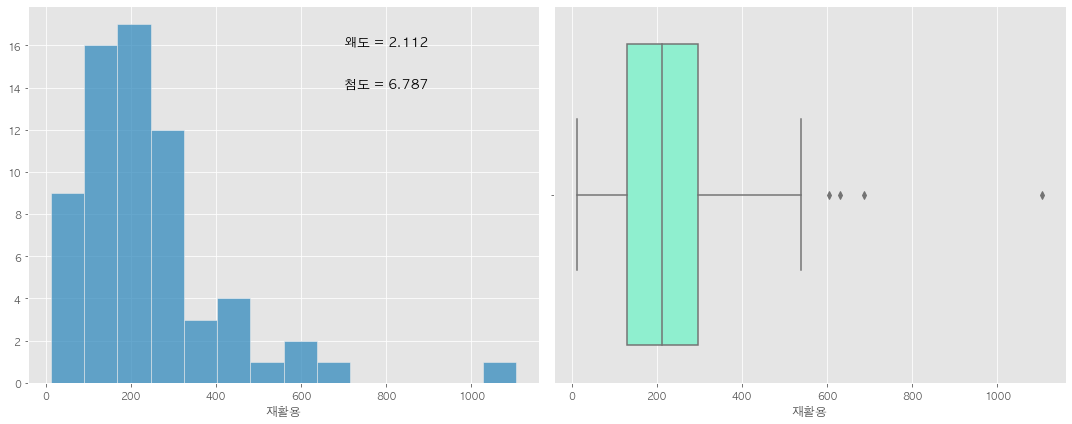

In [28]:
# 재활용 변수 시각화
재활용_왜도 = np.round(stats.skew(merge_data['재활용']), 3)
재활용_첨도 = np.round(stats.kurtosis(merge_data['재활용']), 3)

# 시각화 틀 생성
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

# Histogram
sns.histplot(data = merge_data, x = '재활용', ax = axes[0])
axes[0].set_ylabel('')
axes[0].text(700, 16, '왜도 = {}'.format(재활용_왜도), fontsize = 13)
axes[0].text(700, 14, '첨도 = {}'.format(재활용_첨도), fontsize = 13)

# Boxplot
sns.boxplot(data = merge_data, x = '재활용', color = 'aquamarine', ax = axes[1])

fig.tight_layout()

- 서울, 경기, 인천 데이터의 재활용 배출량 분포를 확인해보면 왼쪽으로 치우쳐져 있으며, 이상치가 존재함을 확인할 수 있다.

- 재활용 변수의 이상치를 상한, 하한값으로 대체, 로그변환, Robust Scaler, Standard Scaler을 수행해준 뒤 분포를 확인해보자.

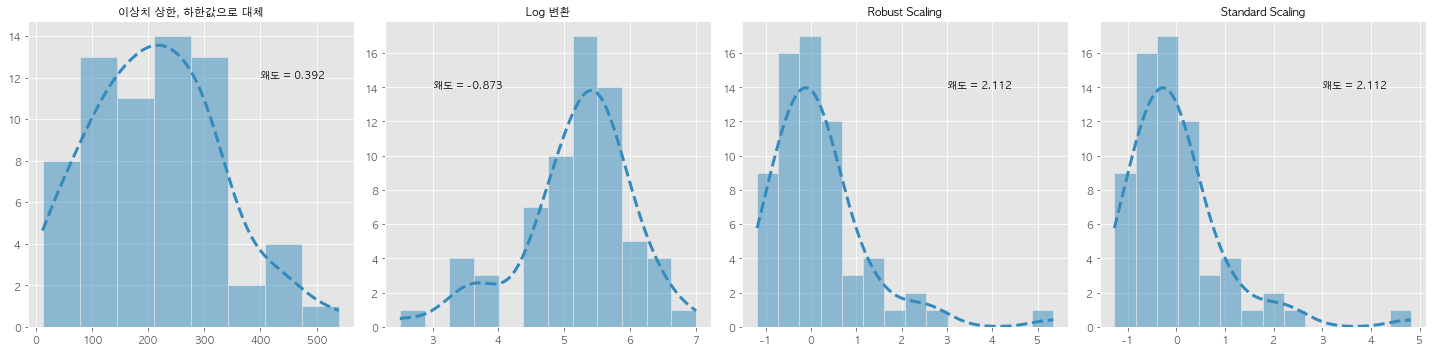

In [29]:
# 이상치를 상한, 하한값으로 대체
대체_재활용 = outlier_transformer(raw_data = merge_data, column = '재활용', weight = 1.5)

# 재활용 변수에 로그 취해주기
로그_재활용 = np.log(merge_data['재활용'])

# Robust Scaler
robust = RobustScaler()
robust_recycle = pd.Series(robust.fit_transform(np.array(merge_data['재활용']).reshape(66, -1)).reshape(-1))

# Standard Scaler
standard = StandardScaler()
standard_recycle = pd.Series(standard.fit_transform(np.array(merge_data['재활용']).reshape(66, -1)).reshape(-1))

# 시각화 틀 생성
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 5))

sns.histplot(대체_재활용, kde = True, line_kws = {'linewidth' : 3, 'linestyle' : '--'}, ax = axes[0])
axes[0].set_title('이상치 상한, 하한값으로 대체', fontsize = 11)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].text(400, 12, '왜도 = {}'.format(np.round(stats.skew(대체_재활용), 3)))

sns.histplot(로그_재활용, kde = True, line_kws = {'linewidth' : 3, 'linestyle' : '--'}, ax = axes[1])
axes[1].set_title('Log 변환', fontsize = 11)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].text(3, 14, '왜도 = {}'.format(np.round(stats.skew(로그_재활용), 3)))

sns.histplot(robust_recycle, kde = True, line_kws = {'linewidth' : 3, 'linestyle' : '--'}, ax = axes[2])
axes[2].set_title('Robust Scaling', fontsize = 11)
axes[2].set_ylabel('')
axes[2].text(3, 14, '왜도 = {}'.format(np.round(stats.skew(robust_recycle), 3)))

sns.histplot(standard_recycle, kde = True, line_kws = {'linewidth' : 3, 'linestyle' : '--'}, ax = axes[3])
axes[3].set_title('Standard Scaling', fontsize = 11)
axes[3].set_ylabel('')
axes[3].text(3, 14, '왜도 = {}'.format(np.round(stats.skew(standard_recycle), 3)))

fig.tight_layout()

- 단순 대체, Log, Robust, Standard 총 4가지의 방법을 사용하여 **재활용** 변수를 Scaling 해주었다.

- 4가지의 방법 중 이상치를 상한, 하한값으로 대체해주었을 때 왜도가 0에 가장 가까움을 확인할 수 있다.

- 또한, Scaling을 해주기 전보다 왜도가 0에 가까우므로 상한, 하한으로 대체한 변수를 생성해주도록 한다.

In [30]:
print('Shape of merge data *Before Create* :', merge_data.shape, '\n')

# 변수 생성
merge_data['대체_재활용'] = 대체_재활용
print('Shape of merge data *After Create* :', merge_data.shape) 

Shape of merge data *Before Create* : (66, 19) 

Shape of merge data *After Create* : (66, 20)


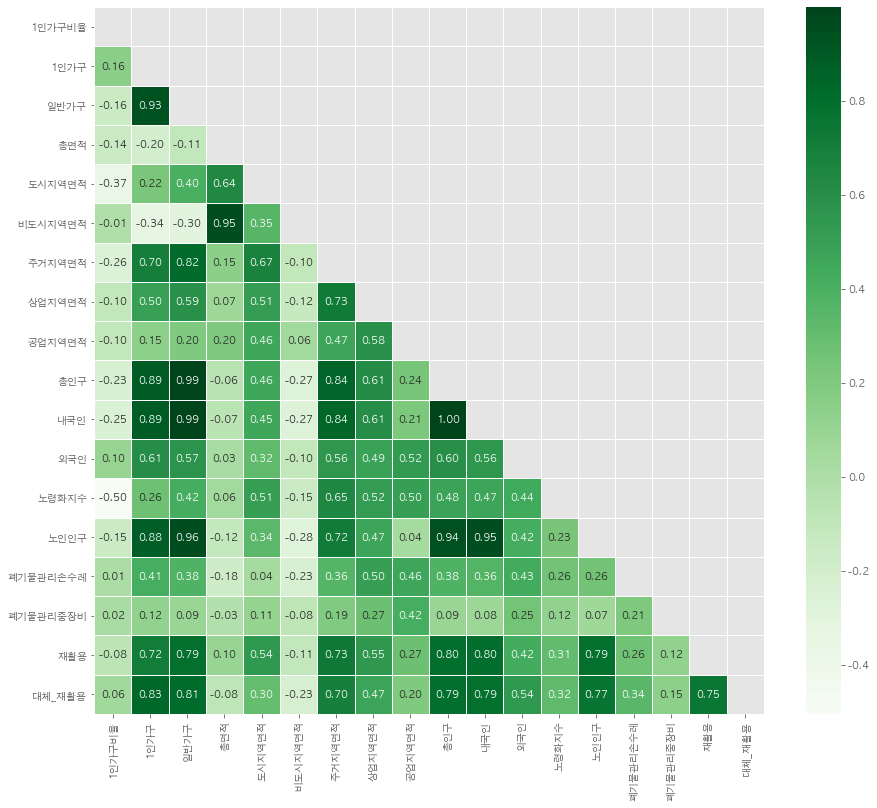

In [31]:
# 히트맵 옵션 지정
mask = np.zeros_like(merge_data.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# 병합 데이터 상관계수 시각화
plt.figure(figsize = (15, 13))

sns.heatmap(merge_data.corr(), cmap = 'Greens', annot = True, fmt = '.2f', linewidths = 0.5, mask = mask)
plt.show()

- **대체_재활용** 변수와 1인가구, 일반가구, 주거지역면적, 총인구, 내국인, 노인인구 총 6개의 변수가 상관계수가 높음을 확인할 수 있다.

- 그 외에도 서로 상관계수가 높은 변수가 확인되며, 후에 다중공선성 문제를 해결하기 위해 변수를 선택해줘야 할 필요성이 있다.

In [32]:
# 데이터 보존을 위해 데이터 복사
data = merge_data.copy()

# 데이터 일부 확인
display(data.head())

,시도명,시군구명,1인가구비율,1인가구,일반가구,총면적,도시지역면적,비도시지역면적,주거지역면적,상업지역면적,공업지역면적,총인구,내국인,외국인,노령화지수,노인인구,폐기물관리손수레,폐기물관리중장비,재활용,대체_재활용
0,서울,종로구,39.40000,24671,62652,23913280,23913280,0,9830557,2937285,0,154969,141810,13159,48.92013,27318,55,0,219.60000,219.60000
1,서울,중구,40.50000,22078,54496,9959983,9959983,0,6037439,3911718,0,130957,118398,12559,45.89101,22974,4,1,224.30000,224.30000
2,서울,용산구,37.70000,35148,93177,21866384,21866384,0,11337245,1557493,0,227181,206678,20503,55.90935,38346,43,11,198.60000,198.60000
3,서울,성동구,33.80000,41488,122770,16859343,16859343,0,9947485,473145,2051234,299688,287914,11774,72.05909,43796,0,1,211.40000,211.40000
4,서울,광진구,39.20000,58714,149905,17062949,17062949,0,11598584,201658,0,359766,338841,20925,71.27158,47681,37,4,253.20000,253.20000


In [33]:
# 반복문을 통해 변수의 왜도 첨도 확인
for column in data.drop(['시도명', '시군구명', '재활용', '대체_재활용'], axis = 1).columns:
    
    # 왜도 계산
    skew_value = stats.skew(data[column])
    
    # 첨도 계산
    kur_value = stats.kurtosis(data[column])
    
    print('{} 변수 왜도 = {}'.format(column, skew_value), '\n')
    print('{} 변수 첨도 = {}'.format(column, kur_value))
    print('-' * 50)

1인가구비율 변수 왜도 = 0.6637708392908518 

1인가구비율 변수 첨도 = 0.30912357657187606
--------------------------------------------------
1인가구 변수 왜도 = 0.9908842699286734 

1인가구 변수 첨도 = 1.2995044930764843
--------------------------------------------------
일반가구 변수 왜도 = 0.9425157510739087 

일반가구 변수 첨도 = 1.0331750218404796
--------------------------------------------------
총면적 변수 왜도 = 1.5273633759880119 

총면적 변수 첨도 = 1.0264171486575284
--------------------------------------------------
도시지역면적 변수 왜도 = 1.611302892887976 

도시지역면적 변수 첨도 = 1.7735719028749282
--------------------------------------------------
비도시지역면적 변수 왜도 = 2.1216368196427906 

비도시지역면적 변수 첨도 = 3.6597375079564927
--------------------------------------------------
주거지역면적 변수 왜도 = 1.4156891720276017 

주거지역면적 변수 첨도 = 1.903156238036682
--------------------------------------------------
상업지역면적 변수 왜도 = 1.3654504457344216 

상업지역면적 변수 첨도 = 0.7728716163579685
--------------------------------------------------
공업지역면적 변수 왜도 = 2.734199006367695 

공업지역면적 변수 

## 5.1 인구관련 변수 탐색

### 5.1.1 1인가구비율

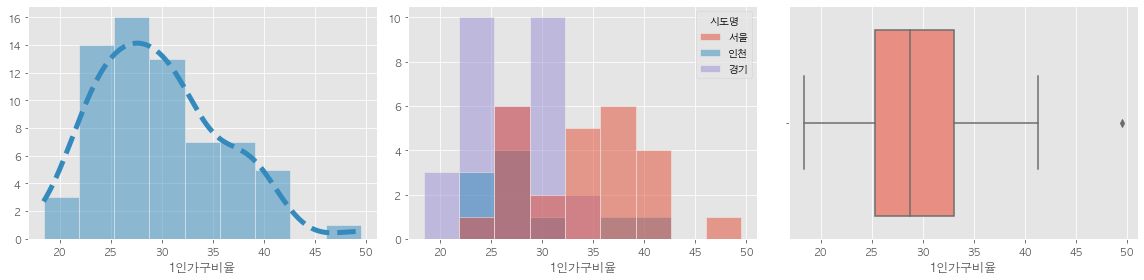

In [35]:
# 1인가구비율
one_variable_plot(plot_data = data, column = '1인가구비율')

- 1인가구비율 변수의 경우 왜도는 **0.6638**, 첨도는 **0.3091**이며, 시각화를 통해 비교적 정규분포를 따른다고 할 수 있다.

- 인천, 경기에 비해 서울의 1인가구비율이 높다는 것을 확인할 수 있다.

상관계수 : 0.0623 

유의확률 : 0.6191 



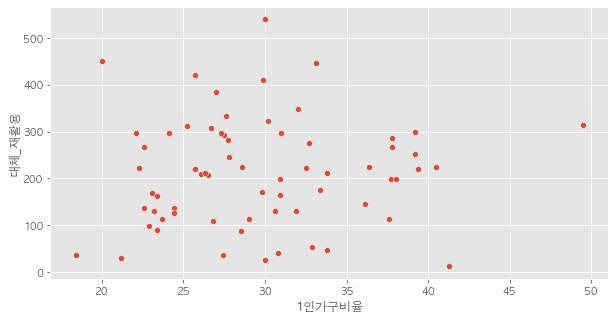

In [36]:
correlation_scatter(plot_data = merge_data, column = '1인가구비율')

- 1인가구비율과 대체_재활용 변수는 상관성이 없다는 결과가 나온것을 확인할 수 있다.

- 또한, 시각화를 통해서도 관계가 없음을 확인할 수 있다.

### 5.1.2 1인가구

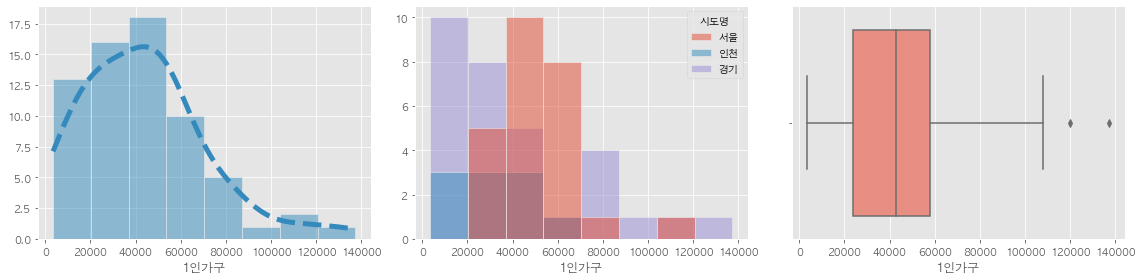

In [38]:
# 1인가구
one_variable_plot(plot_data = data, column = '1인가구')

- 1인가구 변수의 경우 시각화를 통해 왼쪽으로 치우쳐져 있다는 것을 확인할 수 있지만, 왜도의 값이 **0.9909**으로 크지 않음을 확인할 수 있다.

- 2개의 이상치를 상한값으로 대체해준 후, 분포를 살펴보도록 하자.

In [39]:
data['대체_1인가구'] = outlier_transformer(raw_data = data, column = '1인가구', weight = 1.5)

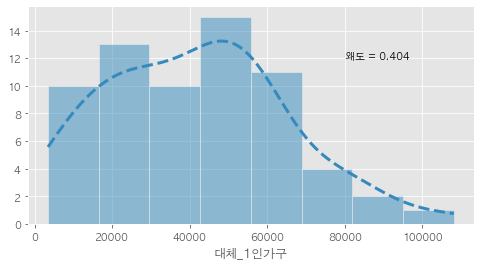

In [40]:
# 시각화 수행
plt.figure(figsize = (8, 4))

sns.histplot(data['대체_1인가구'], kde = True, line_kws = {'linewidth' : 3, 'linestyle' : '--'})
plt.ylabel('')
plt.text(80000, 12, '왜도 = {}'.format(np.round(stats.skew(data['대체_1인가구']), 3)))
plt.show()

- 왜도의 값이 더 줄어들었으므로, 이상치를 상한값으로 대체해준 변수를 사용하도록 하자.

상관계수 : 0.7971 

유의확률 : 0.0 



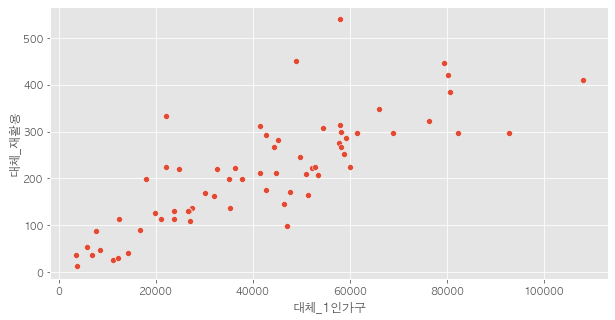

In [41]:
correlation_scatter(plot_data = data, column = '대체_1인가구')

- 상관분석 후 유의한 결과가 나왔으며, 상관계수의 값이 0.7971로 강한 양의 상관관계가 있음을 확인할 수 있다.

- 1인가구비율, 1인가구 변수 대신 대체_1인가구 변수를 사용해주도록 하자.

### 5.1.3 일반가구

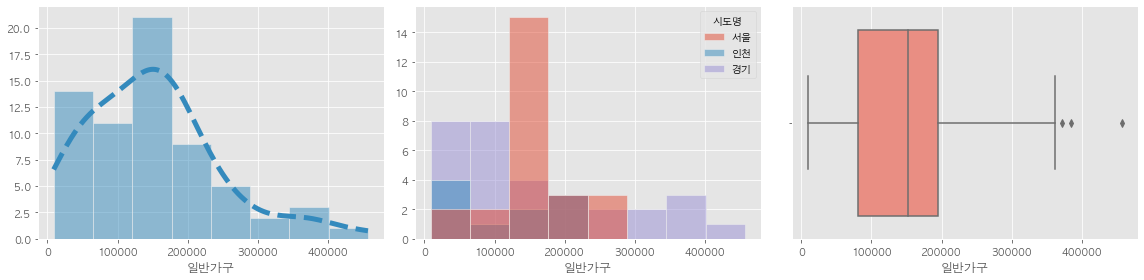

In [42]:
# 일반가구
one_variable_plot(plot_data = data, column = '일반가구')

- 일반가구 변수의 경우에도 시각화를 통해 왼쪽으로 치우쳐져 있다는 것을 확인할 수 있지만, 왜도의 값이 **0.9425**로 크지 않음을 확인할 수 있다.

- 일반가구 변수의 이상치도 상한값으로 대체해주도록 하자.

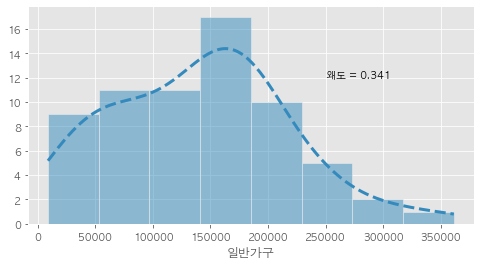

In [43]:
대체_일반가구 = outlier_transformer(raw_data = data, column = '일반가구', weight = 1.5)

# 시각화 수행
plt.figure(figsize = (8, 4))

sns.histplot(대체_일반가구, kde = True, line_kws = {'linewidth' : 3, 'linestyle' : '--'})
plt.ylabel('')
plt.text(250000, 12, '왜도 = {}'.format(np.round(stats.skew(대체_일반가구), 3)))
plt.show()

- 왜도의 값이 더 줄어들었으므로 상한값을 대체한 일반가구 변수를 만들어주도록 한다.

상관계수 : 0.7993 

유의확률 : 0.0 



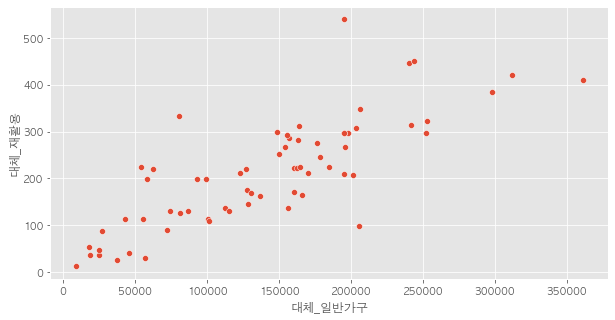

In [44]:
# 이상치를 대체한 일반가구 변수 생성
data['대체_일반가구'] = 대체_일반가구

# 재활용 변수와의 관계 탐색
correlation_scatter(plot_data = data, column = '대체_일반가구')

- 상관분석 결과 유의하다는 결과가 나왔으며, 상관계수의 값이 0.7993으로 강한 양의 상관관계가 있음을 확인할 수 있다.

### 5.1.4 총인구

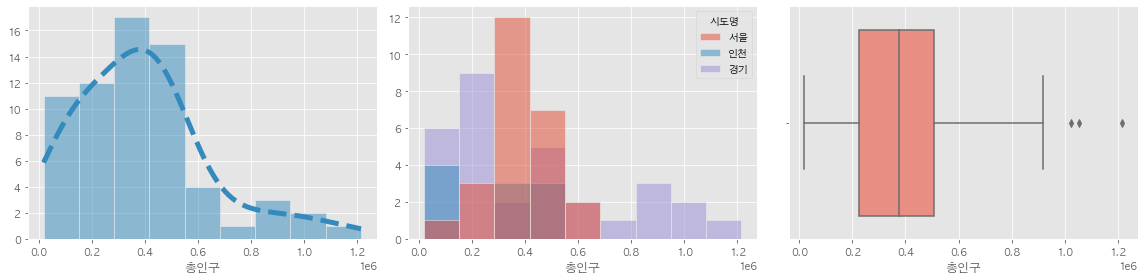

In [45]:
# 총인구
one_variable_plot(plot_data = data, column = '총인구')

- 총인구 변수의 경우 왜도는 **1.0393**으로 이상치를 상한값으로 대체해주도록 하자.

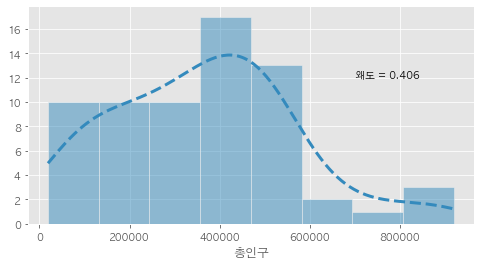

In [46]:
대체_총인구 = outlier_transformer(raw_data = data, column = '총인구', weight = 1.5)

# 시각화 수행
plt.figure(figsize = (8, 4))

sns.histplot(대체_총인구, kde = True, line_kws = {'linewidth' : 3, 'linestyle' : '--'})
plt.ylabel('')
plt.text(700000, 12, '왜도 = {}'.format(np.round(stats.skew(대체_총인구), 3)))
plt.show()

상관계수 : 0.7832 

유의확률 : 0.0 



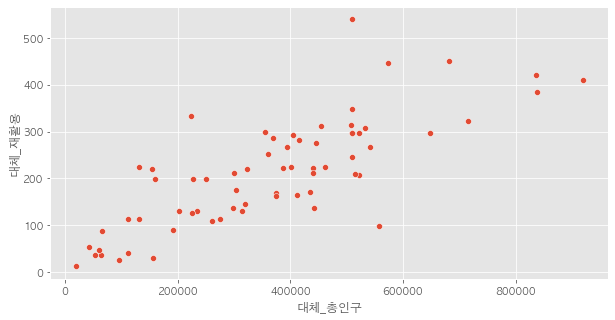

In [47]:
# 대체_총인구 변수생성
data['대체_총인구'] = 대체_총인구

# 재활용 변수와 관계 탐색
correlation_scatter(plot_data = data, column = '대체_총인구')

- 총인구 변수의 이상치를 상한값으로 대체해주었을 때, 왜도의 값이 낮아졌음을 확인할 수 있다.

- 또한, 재활용 변수와의 상관분석과 시각화를 통해 상관성이 있고, 강한 양의 상관관계가 있음을 확인할 수 있다.

- 내국인 변수의 경우 총인구와 비슷할것으로 판단되기 때문에 내국인 변수는 제외하고 외국인 변수만 확인해주도록 하자.

### 5.1.5 외국인

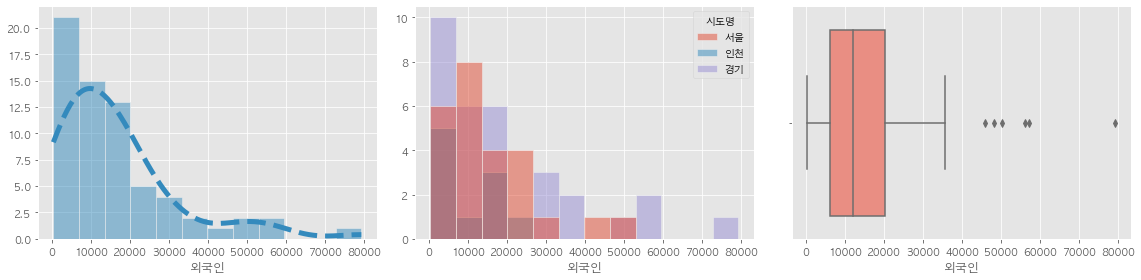

In [48]:
# 외국인
one_variable_plot(plot_data = data, column = '외국인')

- 외국인 변수의 경우에 이전 변수들보다 훨씬 왼쪽으로 치우쳐져 있으며, 왜도의 값은 **1.8343**이다.

- 마찬가지로 이상치를 상한값으로 대체해준 후, 확인해보도록 하자.

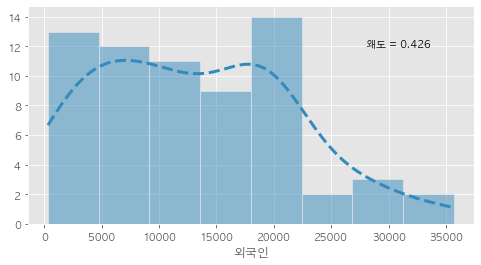

In [49]:
대체_외국인 = outlier_transformer(raw_data = data, column = '외국인', weight = 1.5)

# 시각화 수행
plt.figure(figsize = (8, 4))

sns.histplot(대체_외국인, kde = True, line_kws = {'linewidth' : 3, 'linestyle' : '--'})
plt.ylabel('')
plt.text(28000, 12, '왜도 = {}'.format(np.round(stats.skew(대체_외국인), 3)))
plt.show()

- 이상치를 대체해주었을 때, 정규분포의 형태를 나타내지는 않지만 왜도의 값이 훨씬 줄어들었음을 확인할 수 있다.

상관계수 : 0.5612 

유의확률 : 0.0 



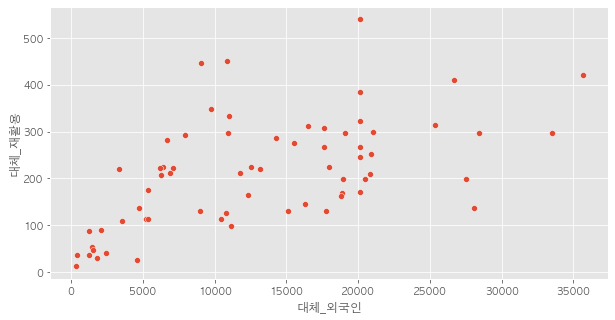

In [50]:
# 대체_외국인 변수생성
data['대체_외국인'] = 대체_외국인

# 재활용 변수와 관계 탐색
correlation_scatter(plot_data = data, column = '대체_외국인')

- 이상치를 대체해주지 않았을 때의 상관계수 값은 0.54 였으며, 이상치를 대체해주었더니 상관계수가 0.02만큼 올라갔음을 확인할 수 있다.

- 외국인 변수 대신 이상치를 대체한 변수를 사용해주도록 하자.

### 5.1.6 노령화 지수

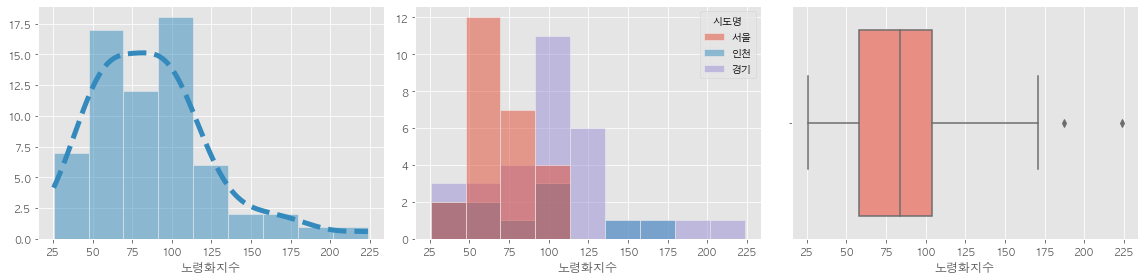

In [51]:
# 노령화 지수
one_variable_plot(plot_data = data, column = '노령화지수')

- 노령화지수 변수도 왼쪽으로 치우쳐져 있으며, 이상치가 존재하므로 이상치를 대체해준 뒤 확인해보도록 하자.

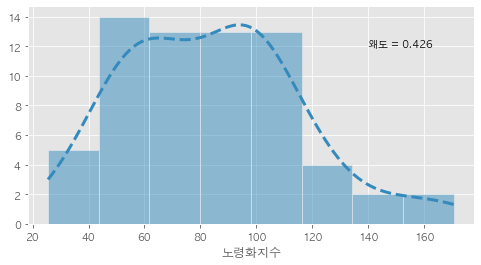

In [52]:
대체_노령화지수 = outlier_transformer(raw_data = data, column = '노령화지수', weight = 1.5)

# 시각화 수행
plt.figure(figsize = (8, 4))

sns.histplot(대체_노령화지수, kde = True, line_kws = {'linewidth' : 3, 'linestyle' : '--'})
plt.ylabel('')
plt.text(140, 12, '왜도 = {}'.format(np.round(stats.skew(대체_외국인), 3)))
plt.show()

상관계수 : 0.3253 

유의확률 : 0.0077 



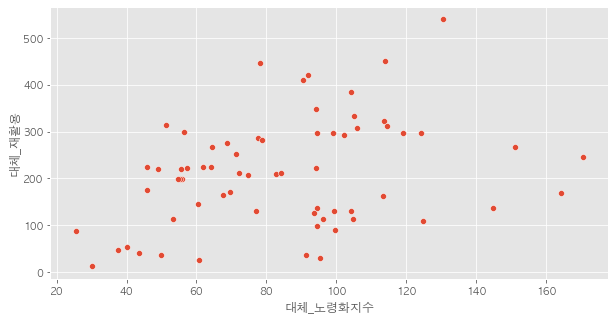

In [53]:
# 대체_노령화지수 변수생성
data['대체_노령화지수'] = 대체_노령화지수

# 재활용 변수와 관계 탐색
correlation_scatter(plot_data = data, column = '대체_노령화지수')

- 이상치를 대체해주었더니 왜도의 값이 **0.426**으로 줄어들었음을 확인할 수 있다. 

- 또한, 이상치를 처리하기 전 상관계수의 값은 0.32였으며, 이상치를 대체해주어도 상관계수의 값이 0.32임을 확인할 수 있다.

- 상관계수의 큰 변화는 없지만 왜도의 값이 줄어들었으므로, 이상치를 처리해준 변수를 사용해주도록 한다.

### 5.1.7 노인인구

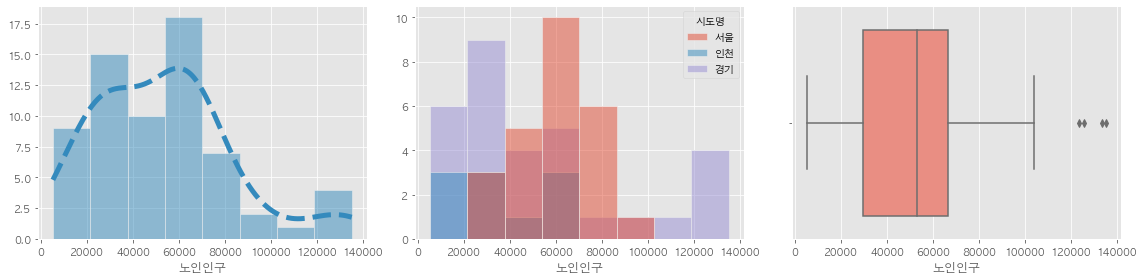

In [54]:
# 노인인구
one_variable_plot(plot_data = data, column = '노인인구')

- 노인인구 변수의 왜도는 **0.8110** 이며, 이상치가 관측되므로 처리해주도록 하자.

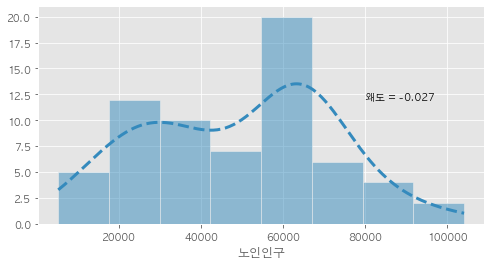

In [55]:
대체_노인인구 = outlier_transformer(raw_data = data, column = '노인인구', weight = 1.5)

# 시각화 수행
plt.figure(figsize = (8, 4))

sns.histplot(대체_노인인구, kde = True, line_kws = {'linewidth' : 3, 'linestyle' : '--'})
plt.ylabel('')
plt.text(80000, 12, '왜도 = {}'.format(np.round(stats.skew(대체_노인인구), 3)))
plt.show()

상관계수 : 0.7559 

유의확률 : 0.0 



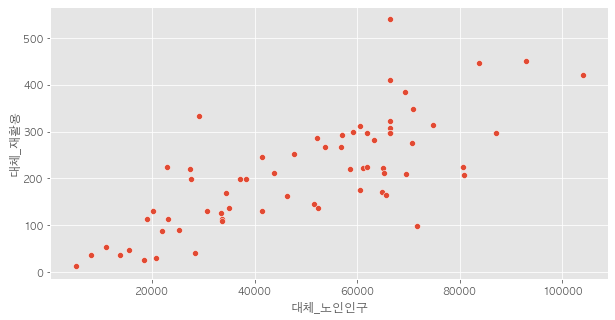

In [56]:
# 대체_노인인구 변수생성
data['대체_노인인구'] = 대체_노인인구

# 재활용 변수와 관계 탐색
correlation_scatter(plot_data = data, column = '대체_노인인구')

- 이상치를 처리해주었더니 왜도의 값이 훨씬 0에 가까워졌음을 확인할 수 있다.

- 이상치를 대체하기 전 상관계수는 0.77로 대체해주었을 때보다 높지만, 왜도가 훨씬 줄어들었으므로 대체해준 변수를 사용하자.

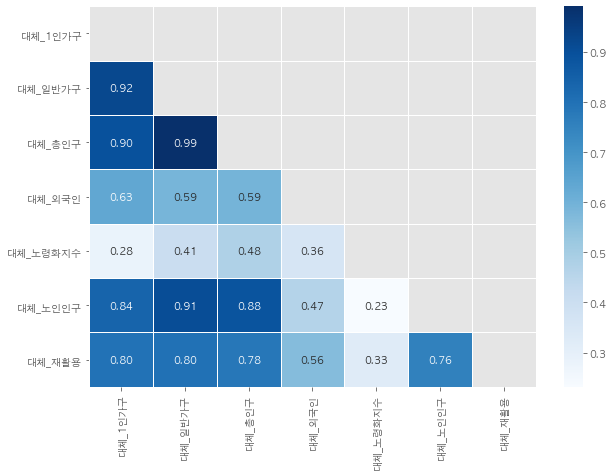

In [57]:
# 인구데이터만 가져온 뒤 상관관계 확인
people_data = data[['대체_1인가구', '대체_일반가구', '대체_총인구', '대체_외국인', '대체_노령화지수', '대체_노인인구', '대체_재활용']]

# 히트맵 옵션 지정
mask = np.zeros_like(people_data.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# 병합 데이터 상관계수 시각화
plt.figure(figsize = (10, 7))

sns.heatmap(people_data.corr(), cmap = 'Blues', annot = True, fmt = '.2f', linewidths = 0.5, mask = mask)
plt.show()

- 재활용 변수와의 상관계수 값이 0.5 이상인 변수 **대체_1인가구, 대체_일반가구, 대체_총인구, 대체_외국인, 대체_노인인구** 5개의 변수를 사용하도록 하자.

- 각 변수들이 재활용 배출량 변수와의 상관계수도 높지만, 각 변수들 간의 상관계수도 높음을 확인할 수 있다.

- 다중공선성 문제가 생길수 있으므로, 각 변수들을 독립변수로 하여 회귀계수의 유의확률과 결정계수 확인

In [58]:
# 데이터 복사
model_data = people_data.drop(['대체_노령화지수'], axis = 1).copy()

# 회귀모형을 구축하기 전에 변수 Scaling
standard = StandardScaler()
model_data[['대체_1인가구', '대체_일반가구', '대체_총인구', '대체_외국인', '대체_노인인구']] = standard.fit_transform(model_data[['대체_1인가구', 
                                                                                                                   '대체_일반가구', 
                                                                                                                   '대체_총인구', 
                                                                                                                   '대체_외국인', 
                                                                                                                   '대체_노인인구']])

# 반복문을 통해서 회귀분석 수행
for column in ['대체_1인가구', '대체_일반가구', '대체_총인구', '대체_외국인', '대체_노인인구']:
    
    X = model_data[column]
    X = sm.add_constant(X)
    
    y = model_data['대체_재활용']
    
    lm_model = sm.OLS(y, X).fit()
    
    print(lm_model.summary(), '\n')

                            OLS Regression Results                            
Dep. Variable:                 대체_재활용   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     111.5
Date:                Sun, 26 Dec 2021   Prob (F-statistic):           1.17e-15
Time:                        23:31:49   Log-Likelihood:                -373.04
No. Observations:                  66   AIC:                             750.1
Df Residuals:                      64   BIC:                             754.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        212.4939      8.617     24.660      0.0

- 5개의 변수를 Scaling 수행해준 후, 각 변수를 독립변수로 지정해 회귀분석을 수행해주었다.

- 5개 변수에 대한 회귀분석 결과, **대체_일반가구** 변수를 독립변수로 사용했을 때 결정계수가 **0.639**로 가장 높음을 확인할 수 있다.

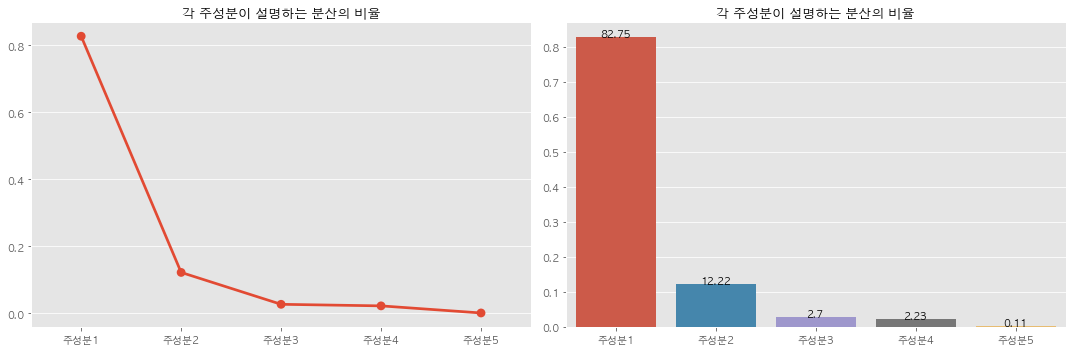

In [59]:
# 총 5개의 주성분을 사용하여 수행
pca = PCA(n_components = 5)
pca_score = pca.fit(model_data.drop(['대체_재활용'], axis = 1))

# 시각화 수행
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

sns.pointplot(x = ['주성분1', '주성분2', '주성분3', '주성분4', '주성분5'], y = pca_score.explained_variance_ratio_, ax = axes[0])
axes[0].set_title('각 주성분이 설명하는 분산의 비율', fontsize = 13)

sns.barplot(x = ['주성분1', '주성분2', '주성분3', '주성분4', '주성분5'], y = pca_score.explained_variance_ratio_, ax = axes[1])
axes[1].set_title('각 주성분이 설명하는 분산의 비율', fontsize = 13)

for index, value in enumerate(pca_score.explained_variance_ratio_):
    axes[1].text(index, value, np.round(value * 100, 2), ha = 'center')

fig.tight_layout()

- 위의 결과는 원래의 데이터 분산의 **82.8**%가 첫 번째 주성분 축에 놓여 있고, **12.2**%가 두 번째 주성분 축에 놓여 있다는 것을 뜻한다.

- 보통 Scree Plot의 **Elbow Point**를 선택하여 사용하며, 현재 그래프에서는 **주성분2** 혹은 **주성분3**까지 선택된다는 것을 알 수 있다.

- 하지만, 첫 번째 주성분을 통해 82.8% 설명력을 가지고 있을 뿐만 아니라 해석의 용이성을 위해 **주성분1**을 선택해주도록 하자.

In [60]:
# 한 개의 주성분으로 수행
pca = PCA(n_components = 1)
pca_score = pca.fit(model_data.drop(['대체_재활용'], axis = 1))

# pca_score.components_ : 각 변수의 가중치 확인
# 대체_1인가구 : 0.46779226
# 대체_일반가구 : 0.48278117
# 대체_총인구 : 0.47773681
# 대체_외국인 : 0.34242779
# 대체_노인인구 : 0.45011497

# 원래의 데이터에 주성분 결과 변수 추가
data['인구_주성분'] = pca_score.transform(model_data.drop(['대체_재활용'], axis = 1))

# 주성분 결과로 만들어진 변수와 대체_재활용 변수와의 회귀분석 수행
X = data['인구_주성분']
X = sm.add_constant(X)

y = data['대체_재활용']

# 회귀분석 학습
lm_model = sm.OLS(y, X).fit()

# 결과 확인
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 대체_재활용   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     130.2
Date:                Sun, 26 Dec 2021   Prob (F-statistic):           4.55e-17
Time:                        23:32:11   Log-Likelihood:                -369.71
No. Observations:                  66   AIC:                             743.4
Df Residuals:                      64   BIC:                             747.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        212.4939      8.193     25.935      0.000     196.126     228.862
인구_주성분        45.9547      4.028     11.409      0.000      37.908      54.002
==============================================================================
Omnibus:                       22.171   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.322
Skew:                           1.113   Prob(JB):                     6.46e-10
Kurtosis:                       6.231   Cond. No.                         2.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- PCA 분석을 통해 생성된 가중치를 통해 **인구_지수** 변수를 새로 생성해주었다.

- 새로 생성한 변수와 재활용 간의 회귀분석 결과를 보면 결정계수가 **0.670**임을 확인할 수 있다.

- 또한, 새로 생성한 변수 회귀계수의 유의확률이 매우 작아 유의수준 0.05에서 유의하다고 할 수 있다.

- 따라서 5개의 인구 관련 변수를 대신하여 **인구_지수** 변수를 사용해주도록 하자.

## 5.2 지리관련 변수 탐색

In [61]:
# 데이터 정리
data = data[['시도명', '시군구명', '인구_주성분', '총면적', '도시지역면적', '비도시지역면적', '주거지역면적', '상업지역면적', '공업지역면적', '폐기물관리손수레', '폐기물관리중장비', '재활용', '대체_재활용']]

# 데이터 일부 확인
data.head()

,시도명,시군구명,인구_주성분,총면적,도시지역면적,비도시지역면적,주거지역면적,상업지역면적,공업지역면적,폐기물관리손수레,폐기물관리중장비,재활용,대체_재활용
0,서울,종로구,-1.77772,23913280,23913280,0,9830557,2937285,0,55,0,219.60000,219.60000
1,서울,중구,-2.04909,9959983,9959983,0,6037439,3911718,0,4,1,224.30000,224.30000
2,서울,용산구,-0.68822,21866384,21866384,0,11337245,1557493,0,43,11,198.60000,198.60000
3,서울,성동구,-0.44145,16859343,16859343,0,9947485,473145,2051234,0,1,211.40000,211.40000
4,서울,광진구,0.66452,17062949,17062949,0,11598584,201658,0,37,4,253.20000,253.20000


In [62]:
# 면적관련 변수 요약 통계량 확인
data[['총면적', '도시지역면적', '비도시지역면적', '주거지역면적', '상업지역면적', '공업지역면적']].describe()

,총면적,도시지역면적,비도시지역면적,주거지역면적,상업지역면적,공업지역면적
count,66.00000,66.00000,66.00000,66.00000,66.00000,66.00000
mean,179712259.15152,80513539.07576,99198720.07576,15398788.42424,1698056.04545,3361918.45455
std,244924517.25647,84681541.20058,201754636.85114,10850550.19620,1746739.91670,5457845.07482
min,7194831.00000,0.00000,0.00000,9155.00000,0.00000,0.00000
25%,24554977.25000,24072090.00000,0.00000,8358942.50000,460872.75000,0.00000
50%,46274232.50000,41829405.00000,0.00000,13000488.50000,991298.00000,1336263.00000
75%,244292301.00000,125563221.50000,109185965.25000,18976584.00000,2217870.75000,4238081.75000
max,877651360.00000,349027878.00000,835429403.00000,52937328.00000,6215363.00000,30283971.00000


- 면적에 관련된 변수의 경우 단위가 $m^2$ 이며, 값들이 전체적으로 크다는 것을 확인할 수 있다.

- 또한, 요약통계량을 보면 모든 변수에서 표준편차가 크다는 것도 확인할 수 있다.

- 면적에 관한 변수에 대해서 살펴보면서 이상치를 상한, 하한값으로 대체, 로그변환, Robust Scaling, Standard Scaling, MinMax Scaling 5가지 방법을 사용하여 비교해보도록 하자. 

### 5.2.1 총면적

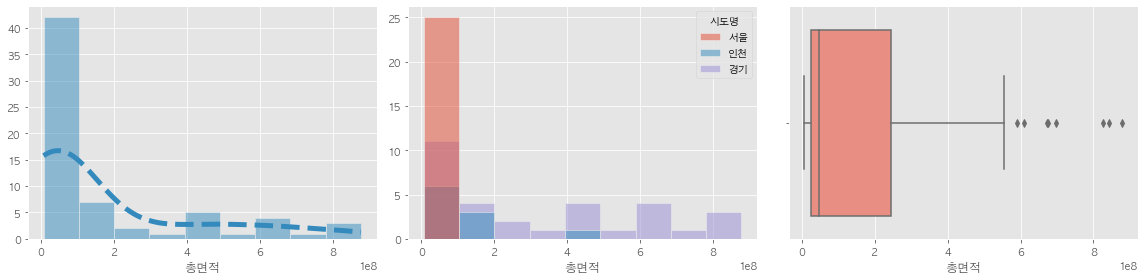

In [63]:
# 총면적 변수 탐색
one_variable_plot(plot_data = data, column = '총면적')

상관계수 : -0.0826 

유의확률 : 0.5095 



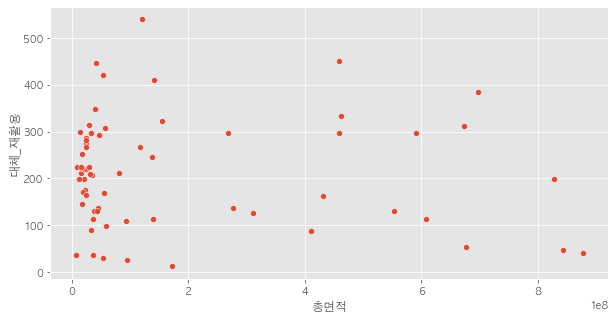

In [64]:
# 총면적 변수와 재활용 변수 탐색
correlation_scatter(plot_data = data, column = '총면적')

- 총면적 변수의 경우 왼쪽으로 치우쳐져 있으며, Boxplot을 통해 이상치를 식별할 수 있다.

- 서울의 경우 경기와 인천에 비해 총면적 값이 낮음을 확인할 수 있다.

- 또한, 재활용 변수와의 상관분석 결과를 보면 상관계수 값이 매우 낮음을 확인할 수 있고, 유의하지 않다는 사실을 확인할 수 있다.

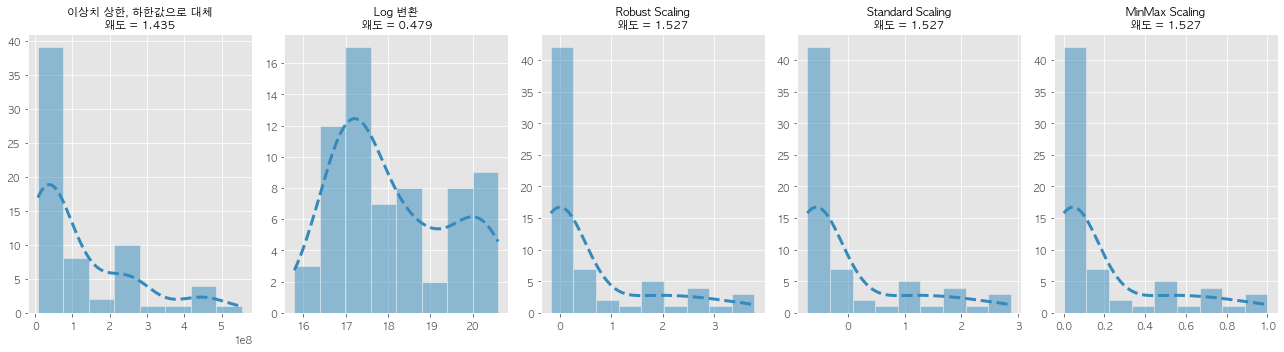

In [65]:
# 총면적 변수를 변환해서 살펴보도록 하자.
log_총면적 = area_detection(raw_data = data, column = '총면적', return_value = 'log')

- 총 5가지의 방법 중에서 **$log$** 를 사용하여 변환해주었을 때, 왜도가 **0.479**로 가장 작음을 확인할 수 있다.

- 따라서 총면적 변수를 **$log$** 변환해준 후 사용해주도록 하자.

상관계수 : -0.0166 

유의확률 : 0.8946 



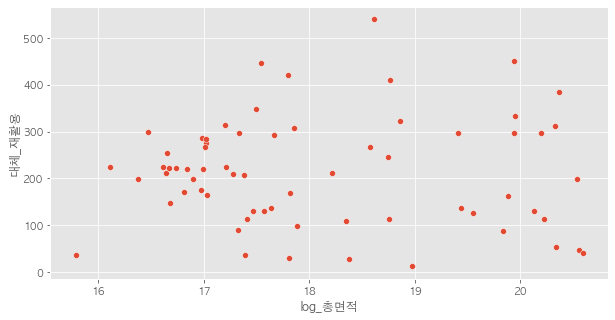

In [66]:
data['log_총면적'] = log_총면적

# 로그 변환한 총면적 변수와 재활용 변수와의 관계를 다시 확인해보도록 하자.
correlation_scatter(plot_data = data, column = 'log_총면적')

- 총면적 변수를 Scaling 수행해준 후, 재활용 변수와 상관분석을 다시 수행했지만 여전히 상관계수가 낮음을 확인할 수 있다.

- 따라서 총면적 변수는 분석에 사용하지 않아도 무방할것 같다.

### 5.2.2 도시지역면적

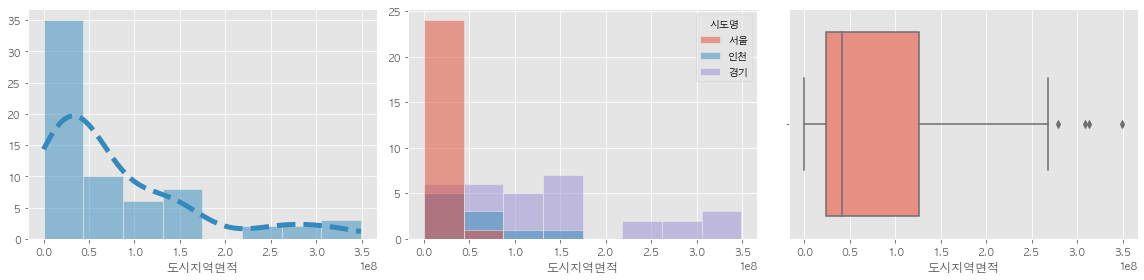

In [67]:
# 도시지역면적 변수 탐색
one_variable_plot(plot_data = data, column = '도시지역면적')

상관계수 : 0.3028 

유의확률 : 0.0135 



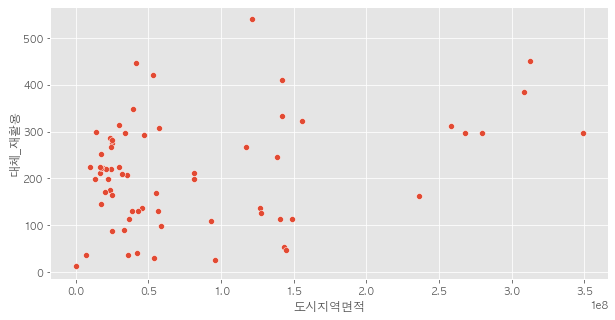

In [68]:
# 도시지역면적 변수와 재활용 변수와의 탐색
correlation_scatter(plot_data = data, column = '도시지역면적')

- 도시지역면적 변수도 마찬가지로 왼쪽으로 치우쳐진 분포를 나타내며, 이상치를 식별할 수 있다.

- 서울의 경우 총면적이 두 지역에 비해 작았기 때문에, 도시지역면적 역시 낮은값을 가지고 있다.

- 상관분석 결과, 유의확률 0.0135는 유의수준 0.05보다 작으므로 대립가설을 기각할 근거가 없다. 따라서, 두 변수간에 약한 양의 상관관계가 있다고 할 수 있다.

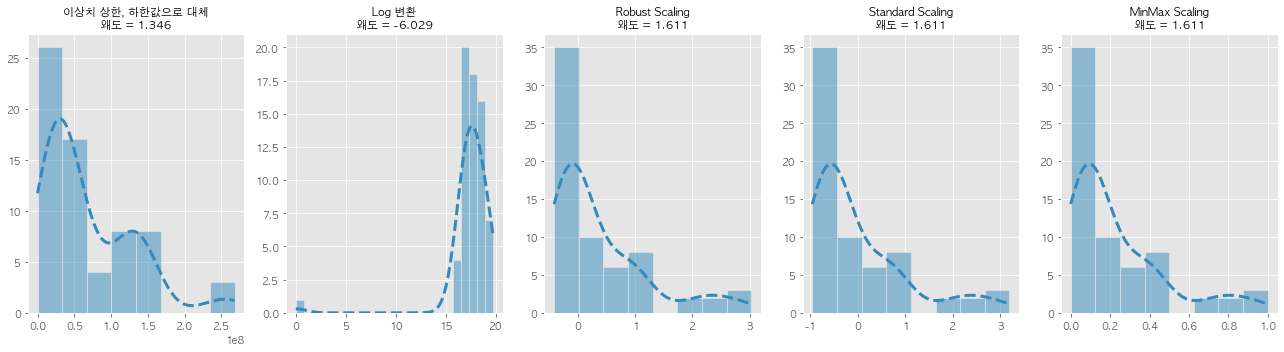

In [69]:
# 도시지역면적 변수를 변환해서 살펴보도록 하자.
area_detection(raw_data = data, column = '도시지역면적')

- 도시지역면적 변수의 경우 이상치를 상한, 하한값으로 대체했을 때의 왜도가 **1.346**으로 가장 작음을 볼 수 있다.

- 하지만 변환하지 않았을 때의 왜도는 **1.611**으로 큰 차이가 나타나지 않고, 대체했을 때의 분포를 보면 쌍봉형을 나타내기 때문에 변환을 수행하지 않고 원 변수를 사용해주도록 하자.

- 비도시지역면적 변수의 경우, 도시지역면적을 제외한 면적을 나타내며 절반의 값이 0을 가지고 있으므로 제외하도록 하자.

### 5.2.3 주거지역면적

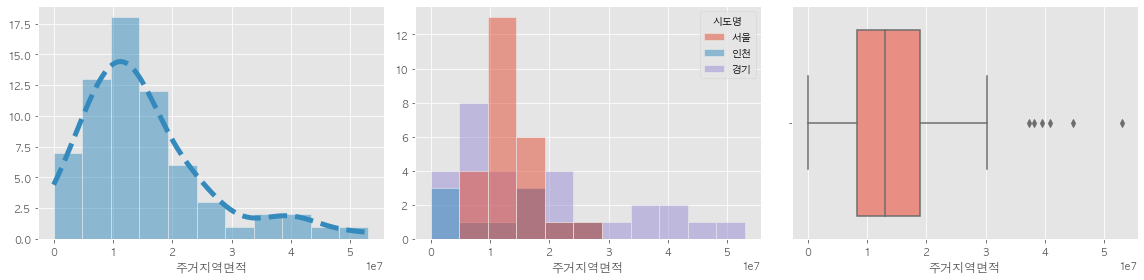

In [70]:
# 주거지역면적 변수 탐색
one_variable_plot(plot_data = data, column = '주거지역면적')

상관계수 : 0.6973 

유의확률 : 0.0 



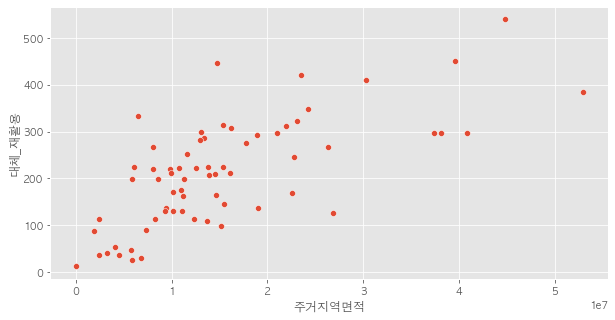

In [71]:
# 주거지역면적 변수와 재활용 변수와의 탐색
correlation_scatter(plot_data = data, column = '주거지역면적')

- 주거지역면적 변수의 경우도 왼쪽으로 치우쳐져 있으나 그 정도가 심하지 않음을 볼 수 있으며, 역시 이상치가 존재함을 확인할 수 있다.

- 재활용 변수와의 상관계수는 0.6973이고, 유의확률이 유의수준 0.05보다 작기 때문에 유의하다고 볼 수 있다.

- 이상치가 존재하기 때문에 변환을 수행해준 후, 다시 살펴보도록 하자.

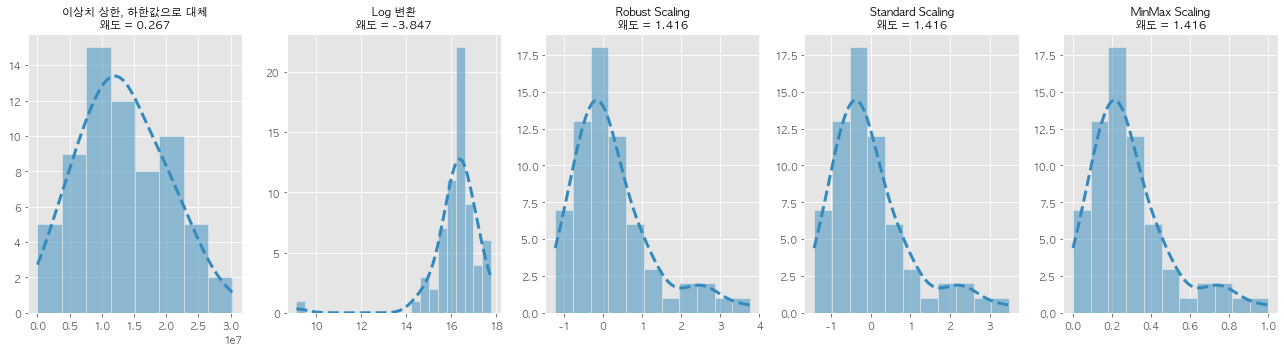

In [72]:
# 주거지역면적 변수를 변환해서 살펴보도록 하자.
replace_주거지역면적 = area_detection(raw_data = data, column = '주거지역면적', return_value = 'replace')

- 주거지역면적 변수의 경우, 이상치를 상한, 하한으로 대체 했을 때의 왜도가 **0.267**로 가장 작음을 확인할 수 있다.

- 주거지역면적 변수의 이상치를 상한, 하한으로 대체한 변수를 생성해주도록 하자.

상관계수 : 0.6446 

유의확률 : 0.0 



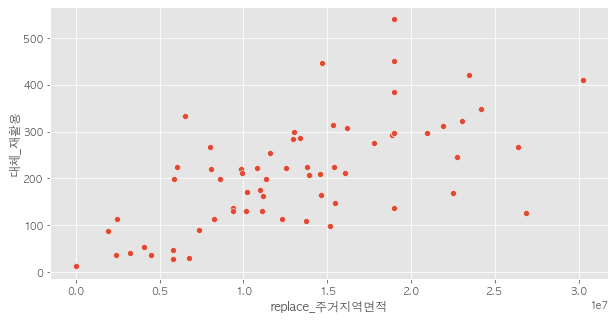

In [73]:
data['replace_주거지역면적'] = replace_주거지역면적

# 대체한 변수와 재활용 변수와의 관계 탐색
correlation_scatter(plot_data = data, column = 'replace_주거지역면적')

- 이상치를 대체해준 후, 재활용 변수와 상관분석을 다시 수행했더니 여전히 유의함을 확인할 수 있었지만, 상관계수의 값이 떨어졌음을 확인할 수 있다.

- 면적 변수에 대해 모든 분석을 수행한 후, 결과를 통해 둘 중 하나의 변수를 선택해주도록 하자.

### 5.2.4 상업지역면적

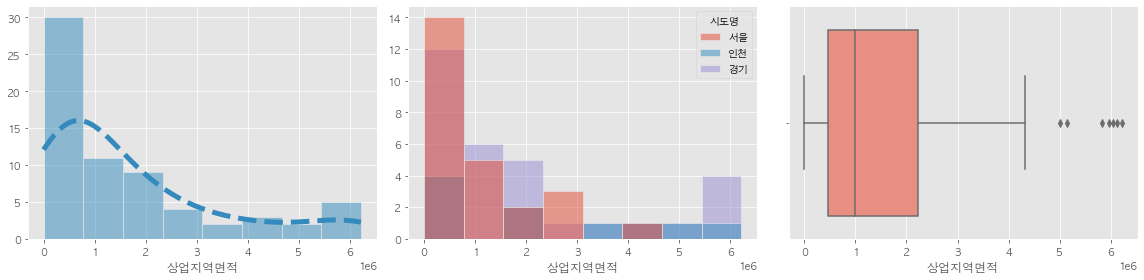

In [74]:
# 상업지역면적 변수 탐색
one_variable_plot(plot_data = data, column = '상업지역면적')

상관계수 : 0.471 

유의확률 : 0.0001 



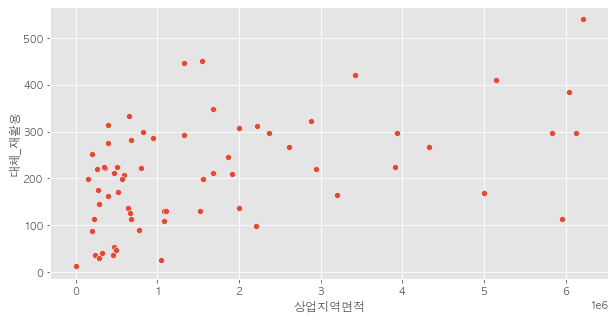

In [75]:
# 재활용 변수와의 관계 탐색
correlation_scatter(plot_data = data, column = '상업지역면적')

- 상업지역면적 변수도 왼쪽으로 치우쳐져 있으며, 이상치를 확인할 수 있다.

- 재활용 변수와의 상관분석 결과, 유의확률이 유의수준 0.05보다 작으므로 대립가설을 기각할 근거가 없다. 따라서 상관계수의 값이 0.471이므로 약한 양의 상관관계가 있다고 할 수 있다.

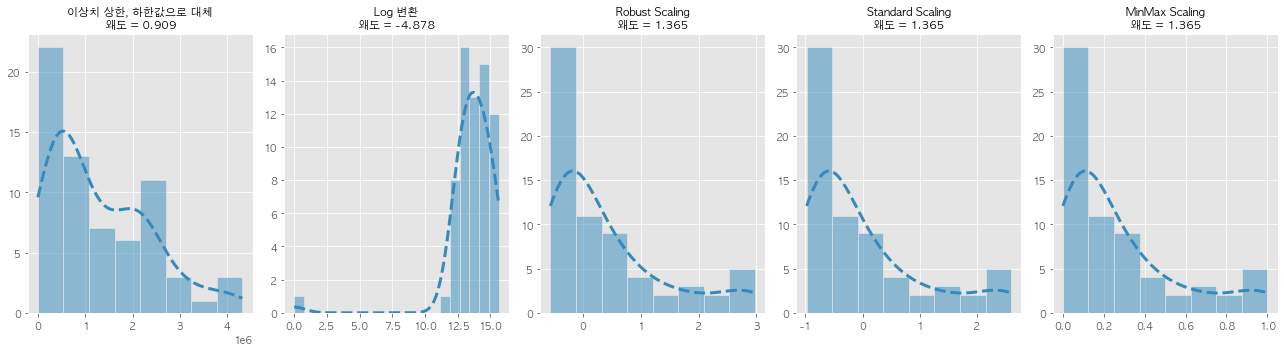

In [76]:
# 상업지역면적 변수를 변환해서 살펴보도록 하자.
area_detection(raw_data = data, column = '상업지역면적')

- 상업지역면적 변수의 경우 이상치를 상한, 하한값으로 대체했을 때의 왜도가 **0.909**으로 가장 작음을 볼 수 있다.

- 변수를 변환하지 않았을 때의 왜도는 **1.365**으로 0.5정도의 차이가 있지만, 왜도의 경우 절대값이 2이하인 경우에는 왜도가 크지 않다고 판단한다.

- 또한, 대체했을 때의 분포를 보면 쌍봉형을 보이기 때문에 변환을 수행하지 않고 원 변수를 사용해주도록 하자.

### 5.2.5 공업지역면적

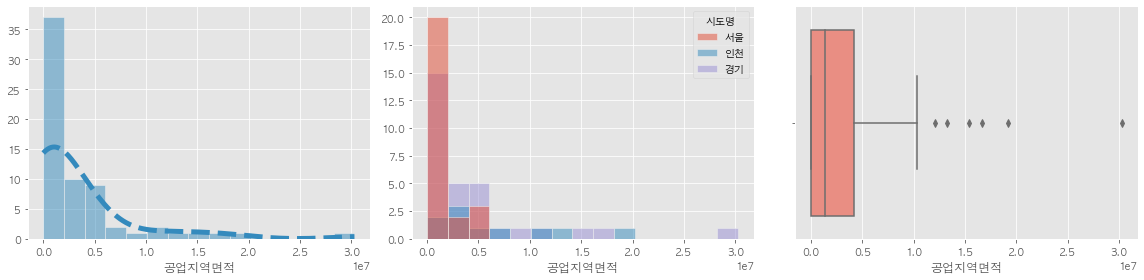

In [77]:
# 공업지역면적 변수 탐색
one_variable_plot(plot_data = data, column = '공업지역면적')

- 서울의 경우 공업지역면적 변수의 값이 대부분 0의 값을 가지기 때문에 분석에 제외하도록 하자.

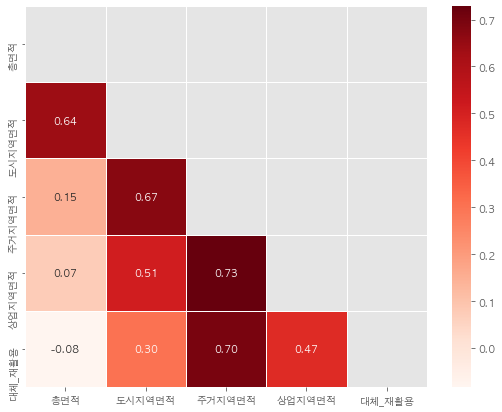

In [78]:
# 면적 관련 변수 중에서 사용할 변수는 '도시지역면적', '주거지역면적', '상업지역면적'
area_data = data[['총면적', '도시지역면적', '주거지역면적', '상업지역면적', '대체_재활용']]

# 히트맵을 옵션 지정
mask = np.zeros_like(area_data.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵 시각화
plt.figure(figsize = (9, 7))

sns.heatmap(area_data.corr(), cmap = 'Reds', annot = True, fmt = '.2f', linewidths = 0.5, mask = mask)
plt.show()

- **도시지역면적**과 **주거지역면적** 상관계수 **0.67**

- **도시지역면적**과 **상업지역면적** 상관계수 **0.51**

- **상업지역면적**과 **주거지역면적** 상관계수 **0.73**

- 지역 관련 변수에서는 재활용 변수와의 상관분석 결과 유의하다고 나타난 **도시지역면적, 주거지역면적, 상업지역면적** 변수를 사용하도록 한다.

- 지역 관련 변수끼리도 서로 상관계수가 높게 나타나지만, 인구 관련 변수에 비해서는 낮기 때문에 후에 Stepwise Method 방법을 통해 선정해주도록 하자.

In [79]:
print('Shape of data *Before Delete* :', data.shape, '\n')

# 분석에 사용할 변수만 저장
data = data[['시도명', '시군구명', '인구_주성분', '도시지역면적', '주거지역면적', '상업지역면적', '폐기물관리손수레', '폐기물관리중장비', '대체_재활용']]
print('Shape of data *After Delete* :', data.shape, '\n')

display(data.head())

Shape of data *Before Delete* : (66, 15) 

Shape of data *After Delete* : (66, 9) 



,시도명,시군구명,인구_주성분,도시지역면적,주거지역면적,상업지역면적,폐기물관리손수레,폐기물관리중장비,대체_재활용
0,서울,종로구,-1.77772,23913280,9830557,2937285,55,0,219.60000
1,서울,중구,-2.04909,9959983,6037439,3911718,4,1,224.30000
2,서울,용산구,-0.68822,21866384,11337245,1557493,43,11,198.60000
3,서울,성동구,-0.44145,16859343,9947485,473145,0,1,211.40000
4,서울,광진구,0.66452,17062949,11598584,201658,37,4,253.20000


## 5.3 폐기물관리관련 변수 탐색

- 이제 폐기물관리손수레, 폐기물관리중장비 두 개의 변수에 대해서 살펴보도록 하자.

In [80]:
# 폐기물 관련 데이터의 요약통계량 확인
display(data[['폐기물관리손수레', '폐기물관리중장비']].describe())

,폐기물관리손수레,폐기물관리중장비
count,66.00000,66.00000
mean,40.33333,2.75758
std,57.00616,3.49091
min,0.00000,0.00000
25%,0.00000,0.00000
50%,20.50000,1.00000
75%,52.50000,4.00000
max,296.00000,16.00000


### 5.3.1 폐기물관리손수레

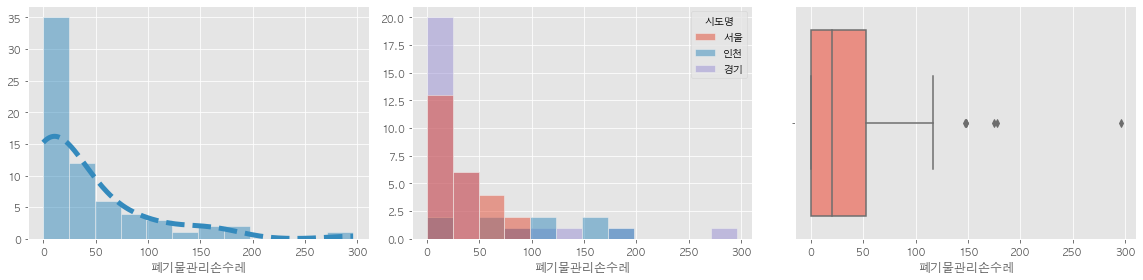

In [82]:
# 폐기물관리손수레 변수 탐색
one_variable_plot(plot_data = data, column = '폐기물관리손수레')

### 5.3.2 폐기물관리중장비

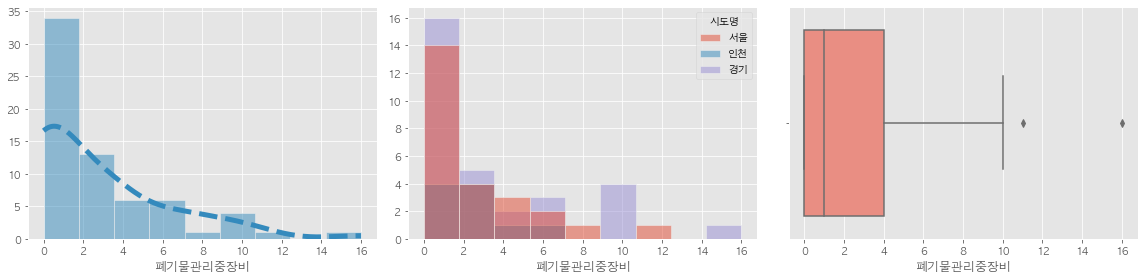

In [83]:
# 폐기물관리중장비 변수 탐색
one_variable_plot(plot_data = data, column = '폐기물관리중장비')

- 폐기물관리손수레, 폐기물관리중장비 변수는 각 장비에 대한 개수를 나타내는 변수다.

- **폐기물관리손수레** 변수는 50개이하, 50개초과를 나타내도록 만들어주고, **폐기물관리중장비** 변수는 보유여부를 나타내도록 만들어주자

In [84]:
print('Shape of data *Before Create* :', data.shape, '\n')

# 새로운 변수 생성
data['폐기물관리손수레_구간'] = data['폐기물관리손수레'].apply(lambda x: 0 if x <= 50 else 1) # 50개 이하 = 0 / 50개 초과 = 1
data['중장비_보유여부'] = data['폐기물관리중장비'].apply(lambda x: 1 if x > 1 else 0) # 보유 X = 0 / 보유 O = 1
print('Shape of data *after Create* :', data.shape)

Shape of data *Before Create* : (66, 9) 

Shape of data *after Create* : (66, 11)


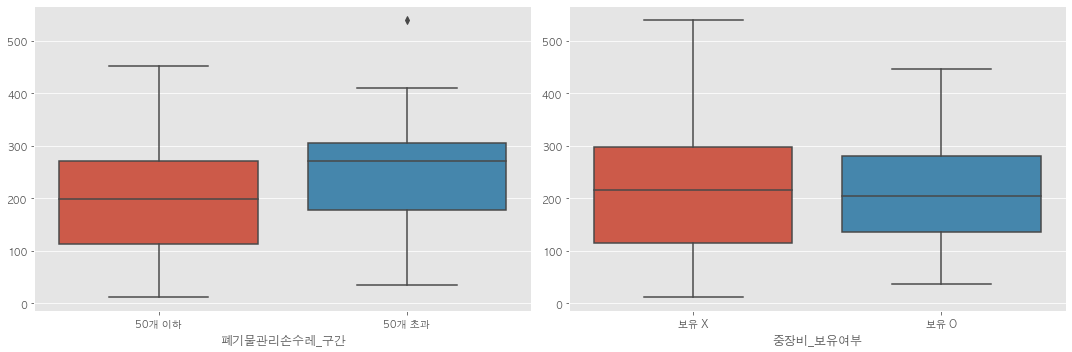

In [85]:
# Boxplot을 통해 재활용 변수와 관계 확인
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

# 폐기물관리손수레_구간
sns.boxplot(x = '폐기물관리손수레_구간', y = '대체_재활용', data = data, ax = axes[0])
axes[0].set_ylabel('')
axes[0].set_xticklabels(['50개 이하', '50개 초과'])

# 중장비 보유여부
sns.boxplot(x = '중장비_보유여부', y = '대체_재활용', data = data, ax = axes[1])
axes[1].set_ylabel('')
axes[1].set_xticklabels(['보유 X', '보유 O'])

fig.tight_layout()

- 폐기물관리손수레 변수를 50 기준으로 나눈 후에 재활용 변수와 살펴보았을 때, 값의 범위는 비슷하지만 **50개 초과**인 경우에 중앙값이 더 높음을 볼 수 있다.

- 중장비 보유여부에 대해서는 큰 차이는 없는것으로 나타난다.

- 따라서 폐기물관리손수레를 구간으로 나눈 변수를 사용해주도록 하자.

In [86]:
# 최종적으로 사용할 변수 추출
model_data = data[['시도명', '시군구명', '인구_주성분', '도시지역면적', '주거지역면적', '상업지역면적', '폐기물관리손수레_구간', '대체_재활용']]

# 회귀모델을 사용하기 위해서 '도시지역면적', '주거지역면적', '상업지역면적' 변수를 표준화 해주도록 한다.
standard = StandardScaler()
model_data[['도시지역면적', '주거지역면적', '상업지역면적']] = standard.fit_transform(model_data[['도시지역면적', '주거지역면적', '상업지역면적']])

# 데이터 일부 확인
model_data.head()

,시도명,시군구명,인구_주성분,도시지역면적,주거지역면적,상업지역면적,폐기물관리손수레_구간,대체_재활용
0,서울,종로구,-1.77772,-0.67351,-0.51711,0.71489,1,219.60000
1,서울,중구,-2.04909,-0.83955,-0.86936,1.27702,0,224.30000
2,서울,용산구,-0.68822,-0.69787,-0.37719,-0.08109,0,198.60000
3,서울,성동구,-0.44145,-0.75745,-0.50625,-0.70663,0,211.40000
4,서울,광진구,0.66452,-0.75503,-0.35292,-0.86325,0,253.20000


- 인구, 지리, 폐기물 총 3부분에 대해서 변수를 탐색하는 과정을 마쳤다.

- EDA 과정을 거쳐 변수를 추려냈음에도 변수가 많기 때문에 회귀분석을 통해 변수를 선택해주도록 한다.

- Python에서 Stepwise Method를 사용하기 위해서 따로 함수를 생성해주어야 하기 때문에 데이터를 저장하고 **R** 을 사용하여 변수를 선택하도록 하자.

```python
model_data.to_csv('./수도권 Data/model_data.csv', encoding = 'CP949')
```